# Imports

In [1]:
import sys
import warnings
import inflection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt

from pandas.plotting         import scatter_matrix
from IPython.display         import Image
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import OneHotEncoder
from sklearn.compose         import make_column_transformer
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics         import recall_score as sk_recall_score
from sklearn.metrics         import precision_recall_curve
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.cluster         import KMeans
from sklearn.calibration     import calibration_curve
from sklearn.naive_bayes     import CategoricalNB
from sklearn.naive_bayes     import GaussianNB
from xgboost                 import XGBClassifier

np.random.seed(123)
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=3)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30
#warnings.filterwarnings('ignore')

# Intro: Loading Data - Helper Functions

## Perguntas:

1. Qual a taxa de Churn atual da empresa?
2. Qual a Performance do modelo em classificar os clientes como churns?
4. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
5. Para quais clientes você daria um incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento)?  
Lembrando que a soma dos incentivos para cada cliente não pode ultrapassar os  R$10,000.

## Dataset Description

**RowNumber**: corresponds to the record (row) number and has no effect on the output.  
**CustomerId**: contains random values and has no effect on customer leaving the bank.  
**Surname**: the surname of a customer has no impact on their decision to leave the bank.  
**CreditScore**: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.  
**Geography**: a customer’s location can affect their decision to leave the bank.  
**Gender**: it’s interesting to explore whether gender plays a role in a customer leaving the bank.  
**Age**: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.  
**Tenure**: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.  
**Balance**: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.  
**NumOfProducts**: refers to the number of products that a customer has purchased through the bank.  
**HasCrCard**: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.  
**IsActiveMember**: active customers are less likely to leave the bank.  
**EstimatedSalary**: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.  
**Exited**: whether or not the customer left the bank. (0=No,1=Yes)

##  Helper Functions

### Data Handling:

In [2]:
def get_data(infile='data/churn.csv'):
    return pd.read_csv(infile)

def rename_cols(df):
    snake_case = lambda x: inflection.underscore(x)
    df.columns = list(map(snake_case, df.columns))
    rename_dict = {'num_of_products': 'num_products',
                   'has_cr_card': 'credit_card',
                   'is_active_member': 'active_member',
                   'estimated_salary': 'salary'}
    df.rename(columns=rename_dict, inplace=True)
    return df

def feature_eng(df, cols_drop=['row_number', 'customer_id', 'surname']):
    df.drop(columns=cols_drop, inplace=True) 
    # create new cols here
    return df

def reload_data():
    df = get_data()
    df = rename_cols(df)
    return feature_eng(df)

### Tools for Plotting:

In [3]:
def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

In [4]:
def hargs(bins=np.arange(0, 2, 1), hstep='step', lwidth=3, c='r', label='Churn', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

In [5]:
def plot_hist(ax, df, col, bins, normed=False, loc='best', mask=':'):    
    ax.hist(df[mask][col], **hargs(bins=bins, normed=normed))
    ax.hist(df[~mask][col], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax.set_xlabel(col)
    ax.legend(loc=loc)
    
def plot_by_country(ax1, ax2, df, var, bins):
    mask = (df.exited == 1)
    normed = False
    ax1.hist(df.loc[(df.geography == 'Germany'), var], **hargs(bins=bins, normed=normed, c='k', label='GER'))       
    ax1.hist(df.loc[(df.geography == 'Spain'), var], **hargs(bins=bins, normed=normed, c='r', label='SPA'))
    ax1.hist(df.loc[(df.geography == 'France'), var], **hargs(bins=bins, normed=normed, c='b', label='FRA'))
    ax1.set_xlabel(var)
    if var == 'credit_score':
        ax1.legend(loc='upper left')

    normed = True
    ax2.hist(df.loc[(df.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
    ax2.hist(df.loc[(df.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
    ax2.hist(df.loc[(df.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
    ax2.hist(df.loc[(df.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
    ax2.hist(df.loc[(df.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
    ax2.hist(df.loc[(df.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')    
    ax2.set_xlabel(var)
    if var == 'credit_score':
        ax2.legend(loc='upper left')
        
def plot_ratios(ax1, ax2, df, var, bins):
    ratios = []
    normed = False
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
    ratios.append(c1/c2)
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
    ratios.append(c1/c2)
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')    
    ratios.append(c1/c2)
    ax1.set_xlabel(var)
    if var == 'credit_score':
        ax1.legend(loc='upper left')
    
    colors = ['black', 'red', 'blue']
    for ratio, c in zip(ratios, colors):
        ax2.bar(x=np.arange(0, len(ratio), 1), height=ratio, width=1, align='edge', fill=False, edgecolor=c, linewidth=2)
    ax2.set_xticks(np.arange(0, len(ratio) + 1, 1))
    ax2.set_xticklabels(bins, rotation=45)
    ax2.set_xlabel(var)

In [6]:
def draw_grid(ax, ymax=.5):
    ticks = np.arange(0., ymax, .1)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ticks = np.arange(.05, ymax-.05, .1)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=True)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.15)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.05)
    
def draw_rate(ax, df, col):
    table = df.groupby(col).exited.mean().reset_index()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    if col == 'gender':
        ax.set_xticklabels(['Male', 'Female'])
    color = ['red', 'blue'] 
    if len(table) > 2:
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['France', 'Spain', 'Germany'])
        color = ['blue', 'red', 'yellow']
    ax.bar(x=table[col], height=table.exited, width=[0.5]*len(table), color=color)
    ax.set_title(f'Churn Rate by {col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
def draw_rate_country(ax, df, col):
    country = 'Germany'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]-0.1, height=table.exited, width=[0.1, 0.1], color=['yellow', 'yellow'], label=country)
    
    country = 'Spain'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col], height=table.exited, width=[0.1, 0.1], color=['red', 'red'], label=country)

    country = 'France'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]+0.1, height=table.exited, width=[0.1, 0.1], color=['blue', 'blue'], label=country) 

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_title(f'Churn Rate by {col} and Country')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
    ax.legend(loc='upper center')

### Statistics of Pivot Tables:

In [7]:
def print_prop(table):
    name = table.columns.name
    a0, b0 = table[0]
    a1, b1 = table[1]
    tot0, tot1 = a0 + b0, a1 + b1
    tot = tot0 + tot1
    print(f'Total of {name} = {tot}')
    print(f'Proportion of {name}==0: {100.*tot0/tot:.2f}%')
    print(f'Proportion of {name}==1: {100.*tot1/tot:.2f}%')
    print(f'Proportion of {name}==0 that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of {name}==1 that Churned: {100.*b1/tot1:.2f}%')
    
def print_prop3(table):
    name = table.columns.name
    a0, b0 = table['France']
    a1, b1 = table['Spain']
    a2, b2 = table['Germany']
    tot0, tot1, tot2 = a0 + b0, a1 + b1, a2 + b2
    tot = tot0 + tot1 + tot2
    print(f'Total of {name} = {tot}')
    print(f'Proportion of France: {100.*tot0/tot:.2f}%')
    print(f'Proportion of Spain: {100.*tot1/tot:.2f}%')
    print(f'Proportion of Germany: {100.*tot2/tot:.2f}%')
    print(f'Proportion of France that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of Spain that Churned: {100.*b1/tot1:.2f}%')
    print(f'Proportion of Germany that Churned: {100.*b2/tot2:.2f}%')

### Lift Curve

In [8]:
def get_lift_gain(y, y_pred, step=0.1, model='Model', plot=False):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=False, inplace=True)

    x_val = np.arange(step, step + 1, step)
    num_ones = aux_lift['true'].sum()
    N = len(aux_lift)
    ratio_ones = num_ones / N

    lifts = []
    gains = [0]
    for x in x_val:
        num_data = int(np.ceil(x * N)) 
        data_here = aux_lift.iloc[:num_data, :]
        num_ones_here = data_here['true'].sum()
        ratio_ones_here = num_ones_here / num_data
        gains.append(num_ones_here / num_ones)
        lifts.append(ratio_ones_here / ratio_ones)
           
    if plot:
        plot_lift(step, [lifts], [model])
    return lifts, gains

def get_rate(y, y_pred, step=0.1):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=True, inplace=True)

    x_val = np.arange(0, 1, step)
    y_val = []
    for x in x_val:
        xlow = int(np.ceil(x * len(aux_lift))) 
        xhigh = int(np.ceil((x+step) * len(aux_lift))) 
        data_here = aux_lift.iloc[xlow:xhigh, :]
        ratio_ones_here = data_here['true'].sum() / len(data_here)
        y_val.append(ratio_ones_here)

    return y_val

In [288]:
colors = ['red', 'blue', 'black', 'green', 'purple', 'yellow']
def plot_lift(ax, ys, models, step):
    x = np.arange(step, step + 1, step)

    ax.plot(x, np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.plot(x, y, '-', color=color, linewidth=3, markersize=5, label=model)
    ax.set_xlabel('Proportion of Sample')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    ticks = np.arange(0, 1.1, .1)
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.legend(loc='best')
        
    ticks = np.arange(0.1, 1.1, .1)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0.1, 1.)
    ymax = np.ceil(max(max(ys)))
    ticks = np.arange(0, ymax + 1, 1)
    ax.set_yticks(ticks=ticks, minor=False)
    ticks = np.arange(0.5, ymax, .5)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_ylim(0, ymax + .5)
    
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.1)
    
    return ax
    
def plot_rates(ax, ys, models, step):
    x = np.arange(0, 1+step, step)
    ax.plot(x, churn_ratio*np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.bar(x[:-1], y, width=step, align='edge', edgecolor=color, fill=False, label=model, linewidth=2)
    ax.set_title('Churn Rate x Model Threshold')
    ax.set_xticks(x)
    ax.set_xlabel('Predicted Probability of Churn')
    ax.set_ylabel('True Churn Rate')
    ax.legend(loc='upper left')    

    ticks = np.arange(0., 1.2, .2)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    
    return ax

def plot_cum_gain(ax, gains, models, step=0.1):
    ax.plot([0, churn_ratio, 1], [0, 1, 1], 'r--', linewidth=2, label='Ideal Classifier')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

    for gain, model, color in zip(gains, models, colors):
        ax.plot(np.arange(0, 1. + step, step), gain, linewidth=2, color=color, label=model)

    ax.set_title(f'Cumulative Gains')
    ax.set_xlabel(f'Proportion of Sample')
    ax.set_ylabel('Proportion of Churning Clients')
    ax.legend(loc='lower right')

    ticks = np.arange(0., 1.2, .2)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0, 1.)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)

    return ax

## ROI Class

In [10]:
def knapsack(W, wt, val):
    n = len(val)
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    keep = [False] * n
    res = max_val
    w = W
    for i in range(n, 0, -1):
        if res <= 0: break
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

In [414]:
class ROI():
    def __init__(self, df, ytrue, ypred, threshold=0.8, name='XGBoost', seed=42):
        self.df = df.copy()
        self.df['true'] = ytrue
        self.df['pred'] = ypred
        self.df.sort_values('pred', ascending=False, inplace=True)
        self.threshold_ = threshold
        self.name_ = name
        self.seed_ = seed

    def make_LTV(self):
        self.mean_sal = self.df.salary.mean()
        self.df['LTV'] = round(self.df.salary.apply(lambda x: 0.15*x if x < self.mean_sal else 0.2*x), 2)

    def make_churn(self):
        self.df['churn'] = self.df.pred.apply(lambda x: 1 if x >= self.threshold_ else 0)
            
    def get_profit(self):
        profit = 0
        modelchurn = 0
        for i in range(self.ncards_):
            entry = self.df.iloc[i]
            if entry.true:
                profit += entry.LTV
                modelchurn += 1
        self.profit_ = profit - self.investment_
        self.model_churn_ = 100.*modelchurn / self.ncards_
            
    def get_random(self):
        randomdf = self.df.sample(self.ncards_, random_state=self.seed_)
        profit = 0
        randomchurn = 0
        for i in range(self.ncards_):
            entry = randomdf.iloc[i]
            if entry.true:
                profit += entry.LTV
                randomchurn += 1
        self.random_profit_ = profit - self.investment_
        self.random_churn_ = 100.*randomchurn / self.ncards_
        
    def greedy_knapsack(self):
        churndf = self.df.loc[self.df.churn == 1, :].copy()
        churndf.sort_values('LTV', ascending=False, inplace=True)
        greedy = 0
        greedychurn = 0
        i = 0
        n = min(len(churndf), self.ncards_)
        while i < n:
            entry = churndf.iloc[i]
            if entry.true:
                greedy += entry.LTV
                greedychurn += 1
            i += 1
        self.used_cards_ = i
        self.greedy_profit_ = greedy - (n * self.gift_)
        self.greedy_churn_ = 100.*greedychurn / n
        
    def make_gift(self):
        self.incentives_ = [20_000, 200, 100, 50]
        gifts = []
        n = len(self.df)
        for i in range(n):
            entry = self.df.iloc[i]
            if entry.pred >= .99:
                gifts.append(self.incentives_[0])
            elif entry.pred >= .95 and entry.pred < .99:
                gifts.append(self.incentives_[1])
            elif entry.pred >= .90 and entry.pred < .95:
                gifts.append(self.incentives_[2])
            else:
                gifts.append(self.incentives_[3])
        self.df['gift'] = gifts
        
    def random_gift(self):
        randomdf = self.df.sample(self.ncards_, random_state=self.seed_)
        profit = 0
        randomchurn = 0
        for i in range(self.ncards_):
            entry = randomdf.iloc[i]
            if entry.true:
                randomchurn += 1
                if entry.gift < self.incentives_[1] - 1:
                    profit += entry.LTV
        self.realrandom_profit_ = profit - self.investment_
        self.realrandom_churn_ = 100.*randomchurn / self.ncards_
        
    def give_gift(self):
        self.make_gift()
        self.random_gift()
        givedf = self.df[self.df.churn == 1]
        W = int(self.investment_ / self.incentives_[-1])
        vals = givedf.LTV.astype(int).values
        wt = (givedf.gift / self.incentives_[-1]).astype(int).values
        max_val, keep = knapsack(W, wt, vals)
        self.givedf = givedf[keep]
        profit = 0
        modelchurn = 0
        n = len(self.givedf)
        for i in range(n):
            entry = self.givedf.iloc[i]
            if entry.true:
                profit += (entry.LTV - entry.gift)
                modelchurn += 1
            else:
                profit += (0 - entry.gift)
        self.real_profit_ = profit
        self.real_churn_ = 100. * modelchurn / n

    def get_ROI(self):
        self.make_LTV()
        self.make_churn()
        self.get_profit()
        self.get_random()
        self.greedy_knapsack()
        self.give_gift()
        
    def print_performance(self, investment=10_000, gift=100, show=True):
        self.investment_ = investment
        self.gift_ = gift
        self.ncards_ = int(investment / gift)
        self.get_ROI()
        if show:
            print(f'Performance of {self.name_} - selecting the {self.ncards_} clients with highest churn probability:')
            print(f'ROI = ${self.profit_:,.2f}')
            print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.model_churn_:.1f}%')

            print(f'\nPerformance of selecting the {self.used_cards_} richest clients (with Pchurn > {self.threshold_}):')
            print(f'ROI = ${self.greedy_profit_:,.2f}')
            print(f'Percentage of {self.used_cards_} clientes that were correctly identified as churning clients: {self.greedy_churn_:.1f}%')

            print(f'\nPerformance of randomly selecting {self.ncards_} clients:')
            print(f'ROI = ${self.random_profit_:,.2f}')
            print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.random_churn_:.1f}%')

            print(f'\nPerformance of model in selecting clients (in realistic scenario):')
            print(f'ROI = ${self.real_profit_:,.2f}')
            print(f'Percentage of {len(self.givedf)} clientes that were correctly identified as churning clients: {self.real_churn_:.1f}%')
            print(f'Total invested: ${self.givedf.gift.sum():,}')
            
            print(f'\nPerformance of randomly selecting clients (in realistic scenario):')
            print(f'ROI = ${self.realrandom_profit_:,.2f}')
            print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.realrandom_churn_:.1f}%')
        
    def get_results(self, investment=10_000, gift=100):
        self.print_performance(investment=investment, gift=gift, show=False)
        results = {}
        results['model']               = [self.name_]
        results                        = pd.DataFrame.from_dict(results)        
        results['threshold']           = self.threshold_
        results['total_ltv']           = self.df.LTV.sum()
        results['exiting_ltv']         = self.df.loc[self.df.true == 1, 'LTV'].sum()
        results['diff_ltv']            = results.total_ltv - results.exiting_ltv
        results['churn_ltv']           = self.df.loc[self.df.churn == 1, 'LTV'].sum()
        results['pred_ltv']            = results.total_ltv - results.churn_ltv
        results['churn_ratio']         = 100.*self.df.true.sum() / len(self.df.true)
        results['investment']          = self.investment_
        results['ncards']              = self.ncards_
        results['random_roi']          = self.random_profit_
        results['random_churn']        = self.random_churn_
        results['random_ltv']          = results.exiting_ltv - results.random_roi
        results['random_improve']      = results.random_roi / results.exiting_ltv
        results['random_ratio']        = results.random_churn / results.churn_ratio
        results['top100_prob_roi']     = self.profit_
        results['top100_prob_churn']   = self.model_churn_
        results['top100_prob_ltv']     = results.exiting_ltv - results.top100_prob_roi
        results['top100_prob_improve'] = results.top100_prob_roi / results.random_roi
        results['top100_prob_ratio']   = results.top100_prob_churn / results.random_churn
        results['top100_prob_eps']     = results.top100_prob_roi / results.exiting_ltv
        results['top100_prob_lift']    = results.top100_prob_churn / results.churn_ratio
        results['top100_rich_ncards']  = self.used_cards_
        results['top100_rich_roi']     = self.greedy_profit_
        results['top100_rich_churn']   = self.greedy_churn_
        results['top100_rich_ltv']     = results.exiting_ltv - results.top100_rich_roi
        results['top100_rich_improve'] = results.top100_rich_roi / results.random_roi
        results['top100_rich_ratio']   = results.top100_rich_churn / results.random_churn
        results['top100_rich_eps']     = results.top100_rich_roi / results.exiting_ltv
        results['top100_rich_lift']    = results.top100_rich_churn / results.churn_ratio
        results['real_random_roi']     = self.realrandom_profit_
        results['real_random_churn']   = self.realrandom_churn_
        results['real_random_ltv']     = results.exiting_ltv - results.real_random_roi
        results['real_random_improve'] = results.real_random_roi / results.exiting_ltv
        results['real_random_ratio']   = results.real_random_churn / results.churn_ratio
        results['real_ncards']         = len(self.givedf)
        results['real_roi']            = self.real_profit_
        results['real_churn']          = self.real_churn_
        results['real_ltv']            = results.exiting_ltv - results.real_roi
        results['real_improve']        = results.real_roi / results.real_random_roi
        results['real_ratio']          = results.real_churn / results.real_random_churn
        results['real_eps']            = results.real_roi / results.exiting_ltv
        results['real_lift']           = results.real_churn / results.churn_ratio
        return results

In [12]:
def get_ROI(X_val, y_val, yproba, threshold=.8, name='XGBoost', investment=10_000, gift=100):
    roi = ROI(X_val, y_val, yproba, threshold=threshold, name=name)
    roi.print_performance(investment=investment, gift=gift)
    return roi

##  Loading the Data

In [13]:
df1 = pd.read_csv('data/churn.csv')
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Descriptive Analysis

In [18]:
df2 = df1.copy()

## Rename Columns

In [19]:
df2.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [20]:
df2 = rename_cols(df2)
df2.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_products', 'credit_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

In [21]:
df2.sample(3).T

,2656,445,9505
row_number,2657,446,9506
customer_id,15713267,15803406,15571281
surname,Zimmer,Ross,Ts'ao
credit_score,779,748,651
geography,Spain,France,France
gender,Female,Female,Male
age,34,26,28
tenure,5,1,10
balance,0,77780.3,79563
num_products,2,1,1


In [22]:
df2.sample(3)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited
3773,3774,15747854,Rudd,749,France,Female,35,3,0.00,3,1,1,132649.85,0
3000,3001,15584545,Aksenov,532,France,Female,40,5,0.00,2,0,1,177099.71,0
4773,4774,15709451,Gordon,646,Germany,Female,35,1,121952.75,2,1,1,142839.82,0


## Data Dimensions

In [23]:
nrows, ncols = df2.shape
print(f' Number of rows: {nrows}')
print(f' Number of columns: {ncols}')

 Number of rows: 10000
 Number of columns: 14


## Data Types

In [24]:
#df1.dtypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  object 
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Missing Data

In [25]:
df2.isna().sum()

row_number       0
customer_id      0
surname          0
credit_score     0
geography        0
gender           0
age              0
tenure           0
balance          0
num_products     0
credit_card      0
active_member    0
salary           0
exited           0
dtype: int64

## Fill Missing Data

No need for this in this project.  
(first time ever =p)

## Change Types

In [26]:
print(df2.gender.unique())
df2.gender = df2.gender.map({'Male': 0,'Female': 1})
df2.gender.head()

['Female' 'Male']


0    1
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

In [27]:
print(df2.geography.unique())
df2['country'] = df2.geography.map({'France': 0, 'Spain': 1, 'Germany': 2})
df2.sample(3)

['France' 'Spain' 'Germany']


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
6951,6952,15738889,Shih,658,France,0,42,8,102870.93,1,0,1,103764.55,1,0
4118,4119,15782311,Feng,529,France,0,28,9,0.00,2,1,1,52545.24,0,0
692,693,15665238,Beneventi,745,Germany,0,36,8,145071.24,1,0,0,6078.46,0,2


## Descriptive Statistics

### Check Data, Drop Columns and Create Num/Cat Attributes

In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  int64  
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
 14  country        10000 non-null  int64  
dtypes: float64(2), int64(11), object(2)
memory usage: 1.1+ MB


I will drop some columns for now, the first 2 are useless for prediction and analysis.  
'Surname' could in principle have some info (NLP - bag of words),
but I do not want to use it in the first few iterations.

In [29]:
df2.drop(columns=['row_number', 'customer_id', 'surname'], inplace=True)
df2.sample(2)

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
96,773,Spain,0,41,9,102827.44,1,0,1,64595.25,0,1
8215,687,France,1,61,7,80538.56,1,1,0,131305.37,1,0


In [30]:
num_attr = df2.select_dtypes(include=['uint8', 'int64', 'float64'])
cat_attr = df2.select_dtypes(exclude=['uint8', 'int64', 'float64'])

In [31]:
num_attr.sample(2)

,credit_score,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
4778,737,1,45,2,0.0,2,0,1,177695.67,0,1
2491,612,1,26,4,0.0,2,1,1,179780.74,0,1


In [32]:
cat_attr.sample(2)

,geography
3367,Germany
343,France


### Numerical Descriptions

In [33]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.median)).T
ct2 = pd.DataFrame(num_attr.apply(np.mean)).T

# Dispersion - std, min, max, range, skew, kurtosis
dt1 = pd.DataFrame(num_attr.apply( min )).T
dt2 = pd.DataFrame(num_attr.apply( max )).T
dt3 = pd.DataFrame(num_attr.apply( lambda x: x.max() - x.min() )).T
dt4 = pd.DataFrame(num_attr.apply( np.std )).T
dt5 = pd.DataFrame(num_attr.apply( lambda x: x.skew() )).T
dt6 = pd.DataFrame(num_attr.apply( lambda x: x.kurtosis() )).T

m = pd.concat([dt1, dt2, dt3, ct1, ct2, dt4, dt5, dt6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'median', 'mean', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,median,mean,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,652.000,650.528800,96.648466,-0.071607,-0.425726
1,gender,0.00,1.00,1.00,0.000,0.454300,0.497907,0.183596,-1.966686
2,age,18.00,92.00,74.00,37.000,38.921800,10.487282,1.011320,1.395347
3,tenure,0.00,10.00,10.00,5.000,5.012800,2.892030,0.010991,-1.165225
4,balance,0.00,250898.09,250898.09,97198.540,76485.889288,62394.285254,-0.141109,-1.489412
5,num_products,1.00,4.00,3.00,1.000,1.530200,0.581625,0.745568,0.582981
6,credit_card,0.00,1.00,1.00,1.000,0.705500,0.455818,-0.901812,-1.186973
7,active_member,0.00,1.00,1.00,1.000,0.515100,0.499772,-0.060437,-1.996747
8,salary,11.58,199992.48,199980.90,100193.915,100090.239881,57507.617221,0.002085,-1.181518
9,exited,0.00,1.00,1.00,0.000,0.203700,0.402748,1.471611,0.165671


In [34]:
df1.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,500.95000,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,9000.10000,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,9500.05000,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


### Categorial Attributes

In [35]:
cat_attr.apply( lambda x: x.unique().shape[0])

geography    3
dtype: int64

# Feature Engineering

In [36]:
df3 = df2.copy()

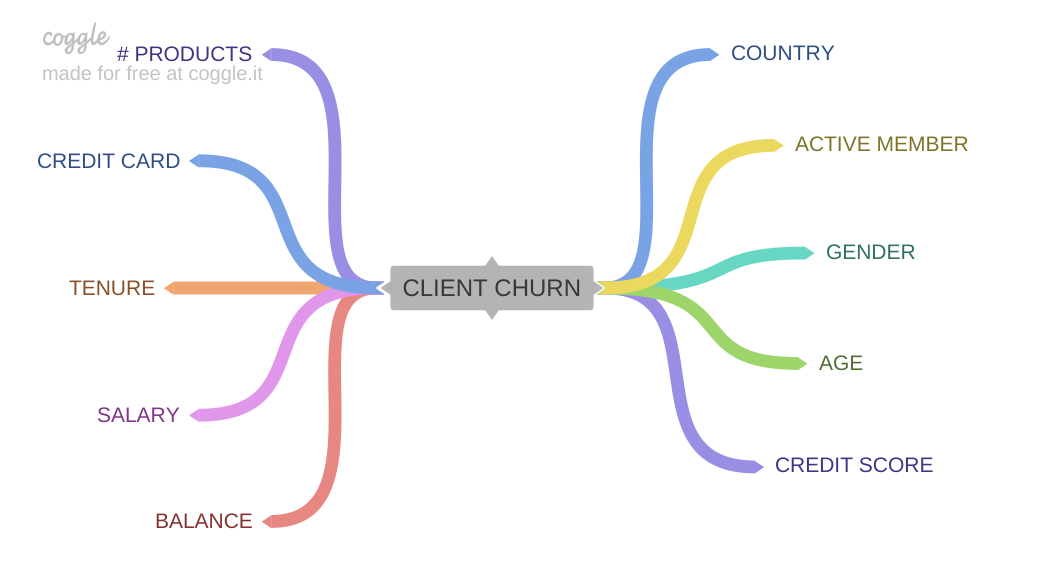

In [37]:
Image('images/CLIENT_CHURN.png')

# Exploratory Data Analysis

In [38]:
df4 = df3.copy()

In [39]:
mask = (df4.exited == 1)

## Numerical Features

### Distributions

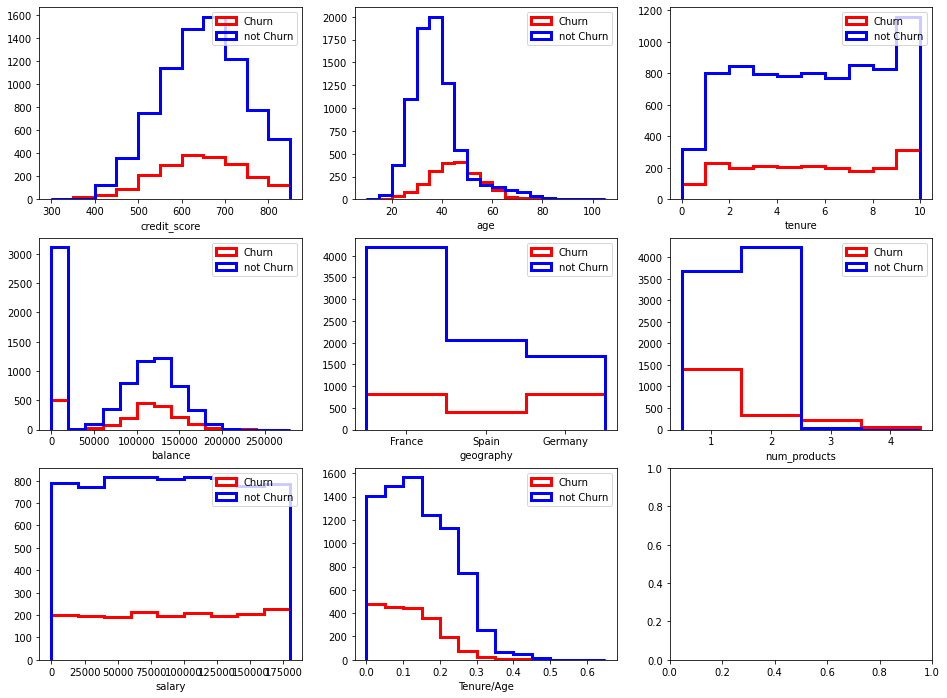

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

cols = ['credit_score', 'age', 'tenure',
        'balance', 'geography', 'num_products',
        'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(-0.5, 3.5, 1), np.arange(.5, 5.5, 1),
        np.arange(0, 200_000, 20_000)]

normed = False
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.savefig('images/distributions.png')
plt.show()

### Normalized Distributions

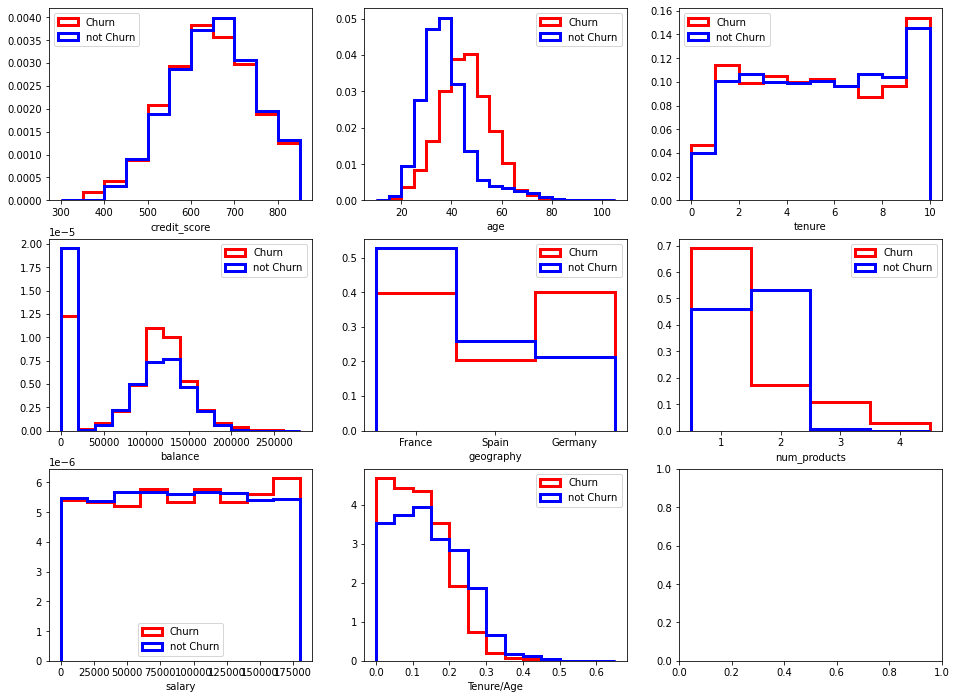

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

normed = True
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ax[0, 0].legend(loc='upper left')
ax[0, 2].legend(loc='upper left')
ax[2, 0].legend(loc='lower center')
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.savefig('images/normed_distributions.png')
plt.show()

### Distributions by Country

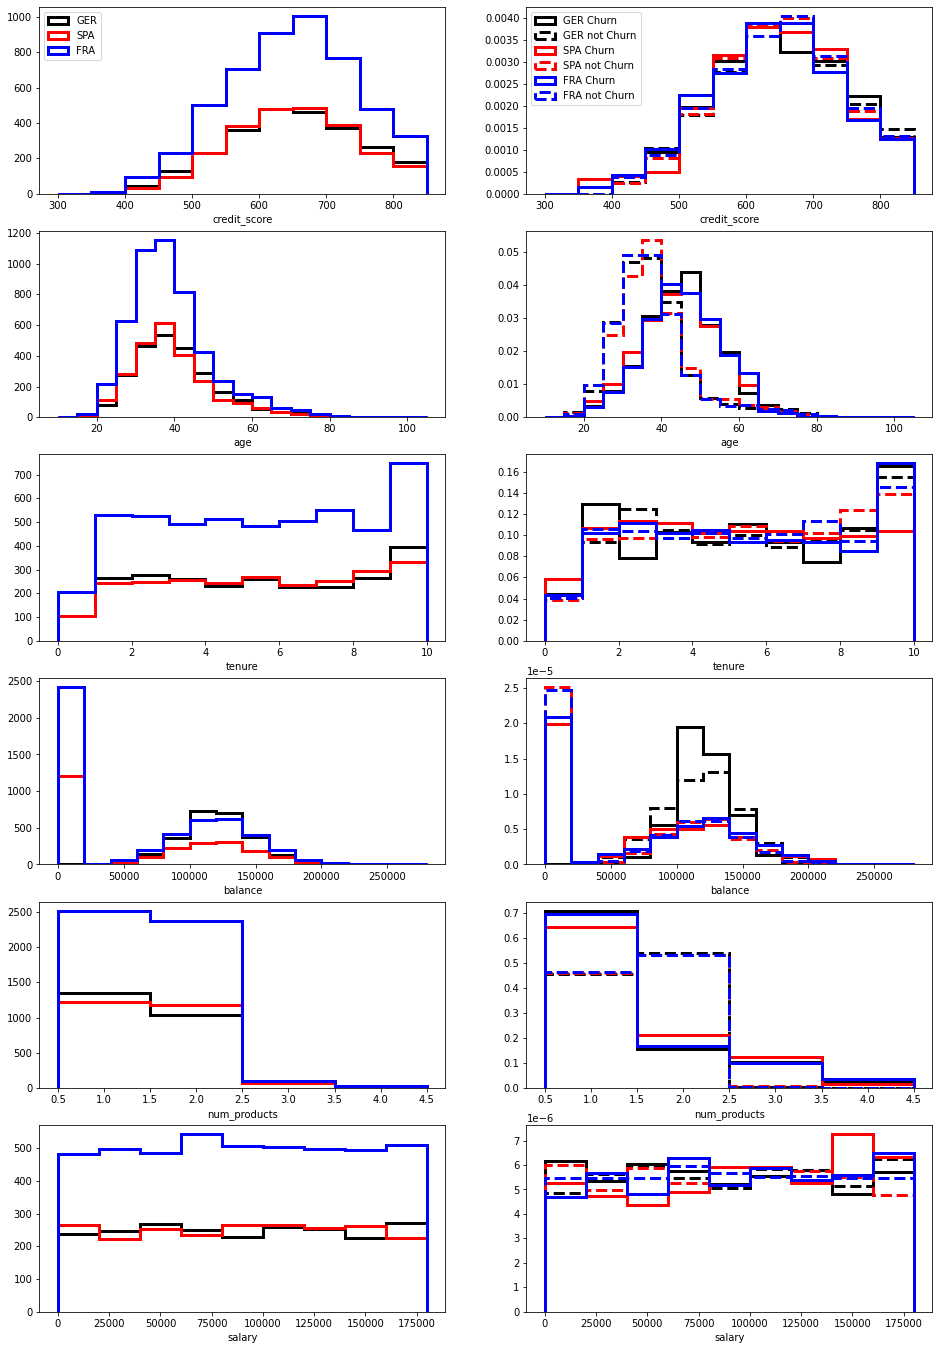

In [42]:
cols = ['credit_score', 'age', 'tenure',
        'balance', 'num_products', 'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(.5, 5.5, 1), np.arange(0, 200_000, 20_000)]

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(16, 4*len(cols)))
for i, (col, ibin) in enumerate(zip(cols, bins)):
    plot_by_country(ax[i, 0], ax[i, 1], df4, col, ibin)

plt.savefig('images/normed_distributions.png')

plt.show()

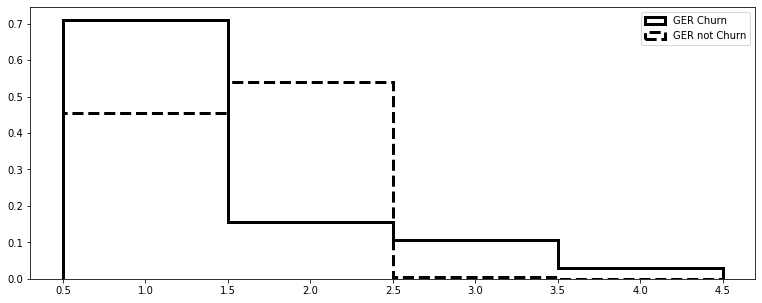

In [43]:
df_dump = df4.loc[df4.geography == 'Germany', 'num_products']

var = 'num_products'
normed = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))

bins = np.arange(.5, 5.5, 1)
ax.hist(df_dump[mask], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
ax.hist(df_dump[~mask], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
ax.legend()

plt.show()

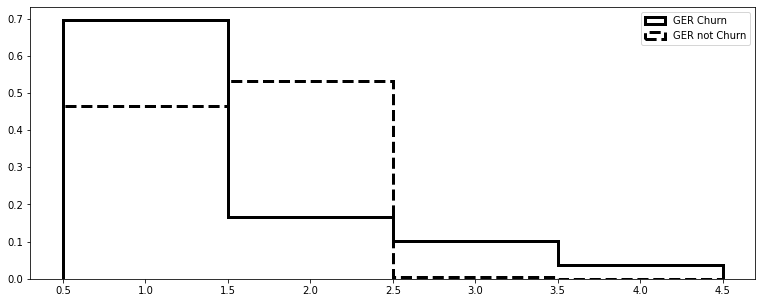

In [44]:
df_dump = df4.loc[df4.geography == 'France', 'num_products']

var = 'num_products'
normed = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))

bins = np.arange(.5, 5.5, 1)
ax.hist(df_dump[mask], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
ax.hist(df_dump[~mask], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
ax.legend()

plt.show()

In [45]:
df4.loc[(df4.balance < 2000)&(df4.geography == 'Germany')]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country


###  Distributions of Churn and Not Churn Ratio

<ipython-input-5-ff88401e3d51>:33: RuntimeWarning: divide by zero encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:33: RuntimeWarning: invalid value encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:36: RuntimeWarning: divide by zero encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:36: RuntimeWarning: invalid value encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:39: RuntimeWarning: divide by zero encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:39: RuntimeWarning: invalid value encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:33: RuntimeWarning: invalid value encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:36: RuntimeWarning: invalid value encountered in true_divide
  ratios.append(c1/c2)
<ipython-input-5-ff88401e3d51>:39: RuntimeWarning: invalid value encountered 

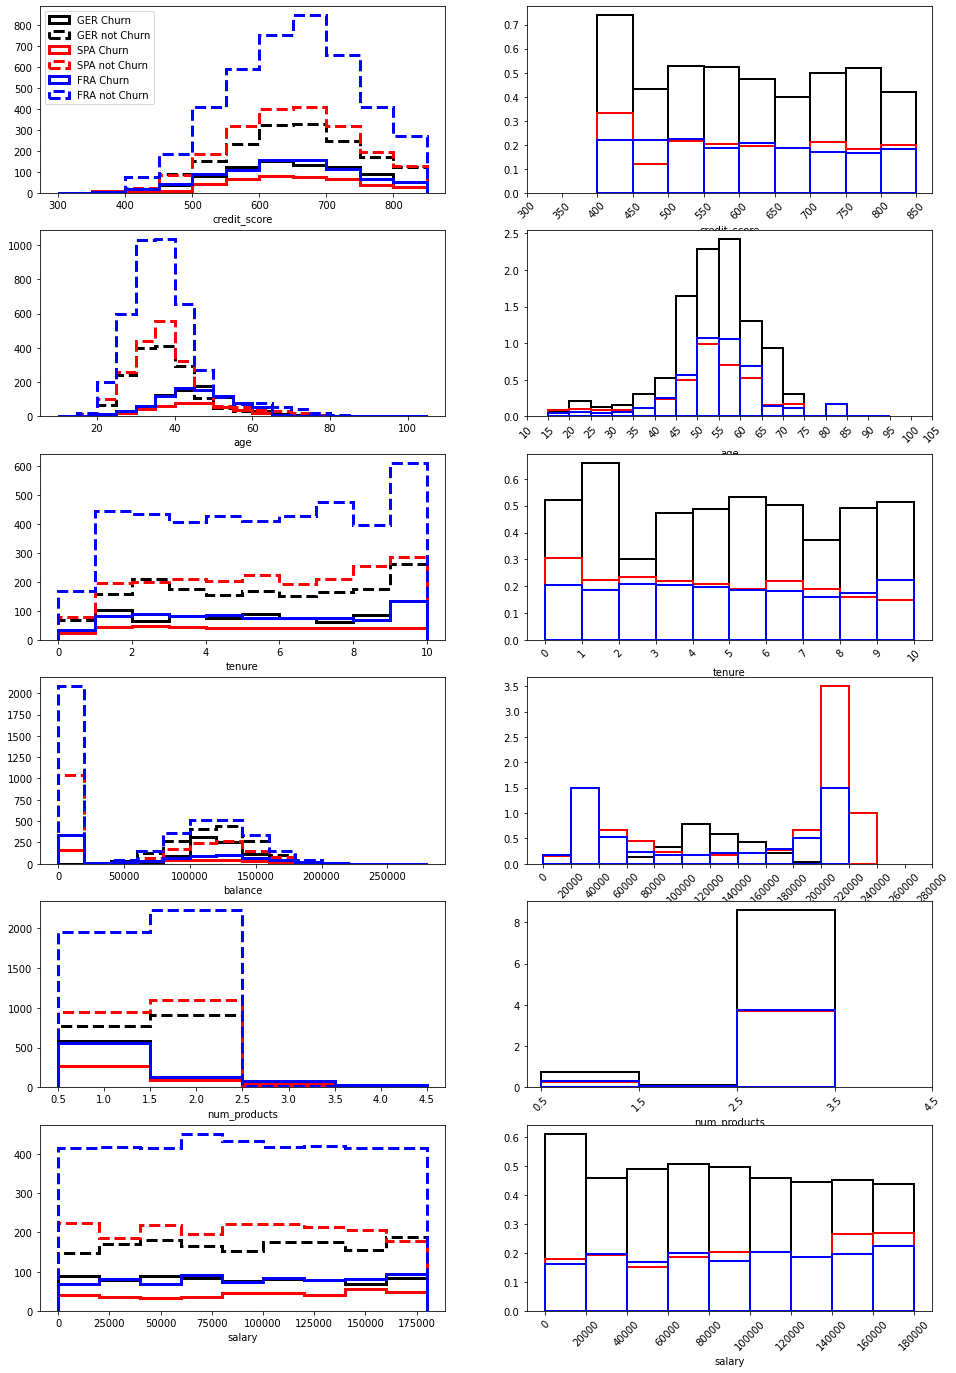

In [46]:
cols = ['credit_score', 'age', 'tenure',
        'balance', 'num_products', 'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(.5, 5.5, 1), np.arange(0, 200_000, 20_000)]

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(16, 4*len(cols)))
for i, (col, ibin) in enumerate(zip(cols, bins)):
    plot_ratios(ax[i, 0], ax[i, 1], df4, col, ibin)

plt.show()

### Correlation Matrices

In [47]:
corr = df4.corr()
corr

,credit_score,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
credit_score,1.000000,0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.008267
gender,0.002857,1.000000,0.027544,-0.014733,-0.012087,0.021859,-0.005766,-0.022544,0.008112,0.106512,0.016936
age,-0.003965,0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.048092
tenure,0.000842,-0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.001418
balance,0.006268,-0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.348700
num_products,0.012238,0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.006180
credit_card,-0.005458,-0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.004036
active_member,0.025651,-0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.012692
salary,-0.001384,0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.007382
exited,-0.027094,0.106512,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.153771


In [48]:
corr.exited.sort_values()

active_member   -0.156128
num_products    -0.047820
credit_score    -0.027094
tenure          -0.014001
credit_card     -0.007138
salary           0.012097
gender           0.106512
balance          0.118533
country          0.153771
age              0.285323
exited           1.000000
Name: exited, dtype: float64

In [14]:
high_corr = ['active_member', 'gender', 'balance', 'geography', 'age']

In [50]:
attributes = ['age', 'balance', 'tenure', 'num_products',
              'credit_score', 'salary', 'country',
              'credit_card', 'active_member', 'gender']

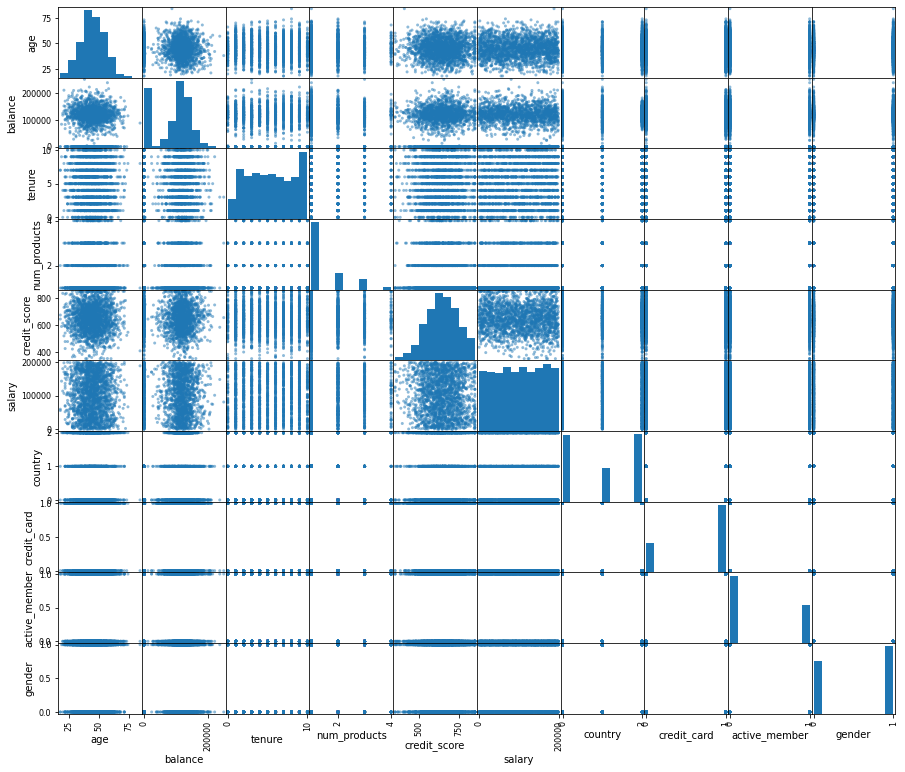

In [51]:
scatter_matrix(df4[mask][attributes], figsize=(15, 13))

plt.savefig('images/corr_churn.png')
plt.show()

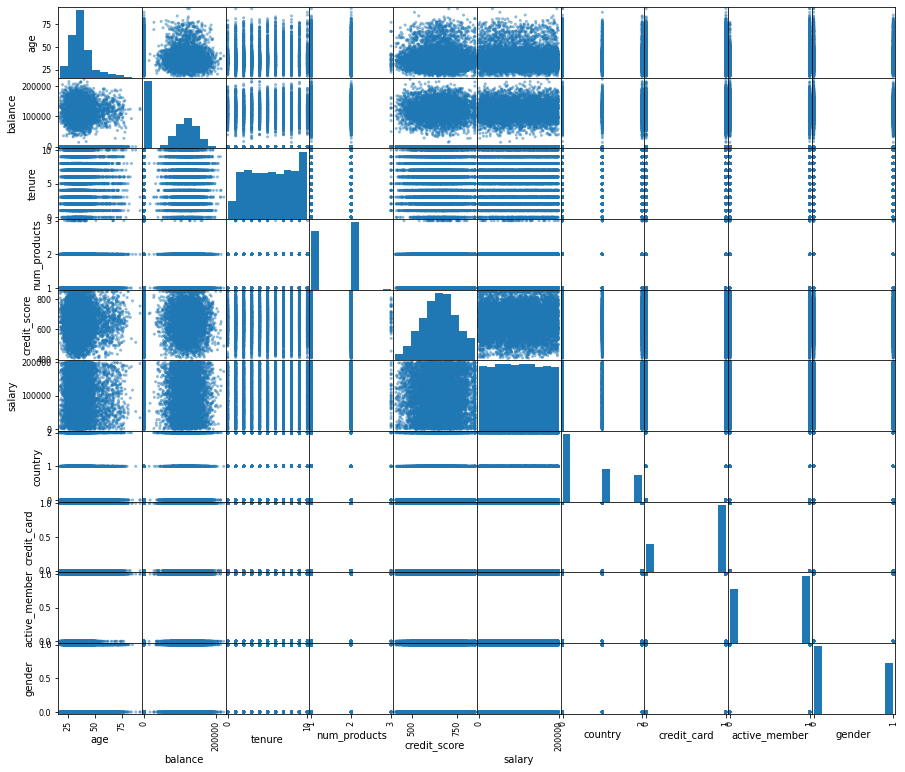

In [52]:
scatter_matrix(df4[~mask][attributes], figsize=(15, 13))
plt.savefig('images/corr_notchurn.png')
plt.show()

## Categorical Features

### Correlations with Numerical Features

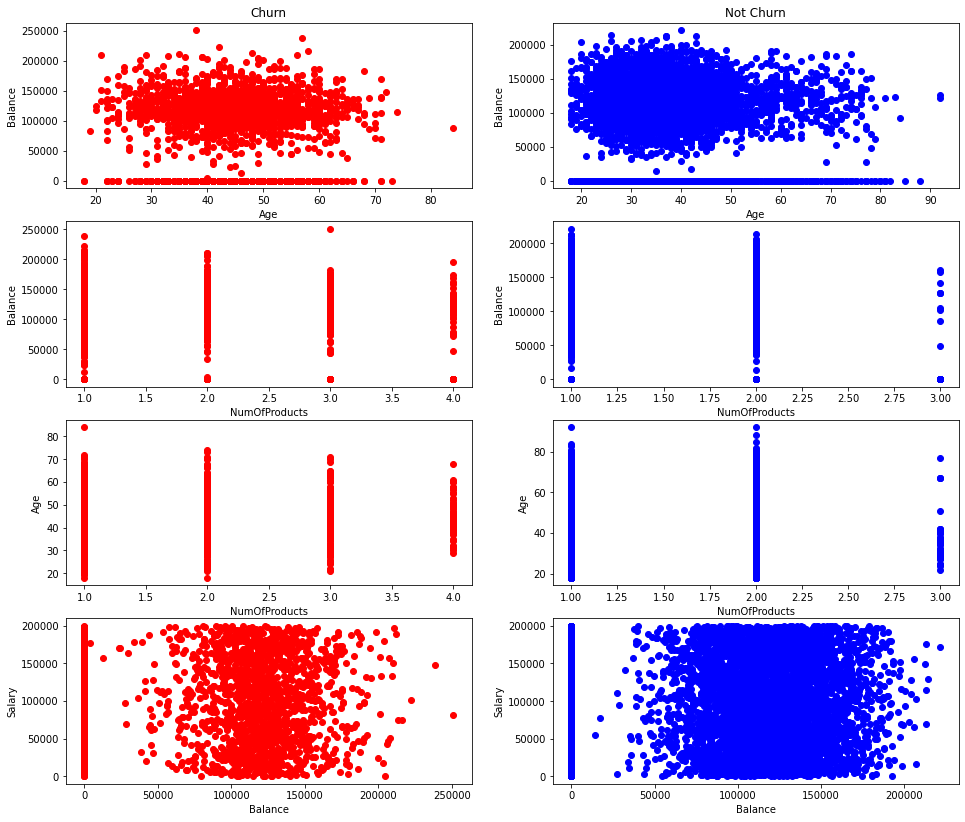

In [53]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = ax

ax1.scatter(x=df4.age[mask], y=df4.balance[mask], label='Churn', color='r')  
ax1.set_title('Churn')
ax1.set_xlabel('Age')
ax1.set_ylabel('Balance')

ax2.scatter(x=df4.age[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax2.set_title('Not Churn')
ax2.set_xlabel('Age')
ax2.set_ylabel('Balance')

ax3.scatter(x=df4.num_products[mask], y=df4.balance[mask], label='Churn', color='r')  
ax3.set_xlabel('NumOfProducts')
ax3.set_ylabel('Balance')

ax4.scatter(x=df4.num_products[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax4.set_xlabel('NumOfProducts')
ax4.set_ylabel('Balance')

ax5.scatter(x=df4.num_products[mask], y=df4.age[mask], label='Churn', color='r')  
ax5.set_xlabel('NumOfProducts')
ax5.set_ylabel('Age')

ax6.scatter(x=df4.num_products[~mask], y=df4.age[~mask], label='not Churn', color='b')
ax6.set_xlabel('NumOfProducts')
ax6.set_ylabel('Age')

ax7.scatter(x=df4.balance[mask], y=df4.salary[mask], label='Churn', color='r')
ax7.set_xlabel('Balance')
ax7.set_ylabel('Salary')

ax8.scatter(x=df4.balance[~mask], y=df4.salary[~mask], label='not Churn', color='b')
ax8.set_xlabel('Balance')
ax8.set_ylabel('Salary')

plt.show()

### Frequency Tables

In [54]:
table = df4.groupby(['exited', 'credit_card']).agg('count').balance.unstack()
print_prop(table)
table

Total of credit_card = 10000
Proportion of credit_card==0: 29.45%
Proportion of credit_card==1: 70.55%
Proportion of credit_card==0 that Churned: 20.81%
Proportion of credit_card==1 that Churned: 20.18%


credit_card,0,1
exited,,
0,2332,5631
1,613,1424


In [55]:
# 0: Male, 1: Female
table = df4.groupby(['exited', 'gender']).agg('count').balance.unstack()
print_prop(table)
table

Total of gender = 10000
Proportion of gender==0: 54.57%
Proportion of gender==1: 45.43%
Proportion of gender==0 that Churned: 16.46%
Proportion of gender==1 that Churned: 25.07%


gender,0,1
exited,,
0,4559,3404
1,898,1139


In [56]:
table = df4.groupby(['exited', 'active_member']).agg('count').balance.unstack()
print_prop(table)
table

Total of active_member = 10000
Proportion of active_member==0: 48.49%
Proportion of active_member==1: 51.51%
Proportion of active_member==0 that Churned: 26.85%
Proportion of active_member==1 that Churned: 14.27%


active_member,0,1
exited,,
0,3547,4416
1,1302,735


In [57]:
table = df4.groupby(['exited', 'geography']).agg('count').balance.unstack()
print_prop3(table)
table

Total of geography = 10000
Proportion of France: 50.14%
Proportion of Spain: 24.77%
Proportion of Germany: 25.09%
Proportion of France that Churned: 16.15%
Proportion of Spain that Churned: 16.67%
Proportion of Germany that Churned: 32.44%


geography,France,Germany,Spain
exited,,,
0,4204,1695,2064
1,810,814,413


### Frequency Plots

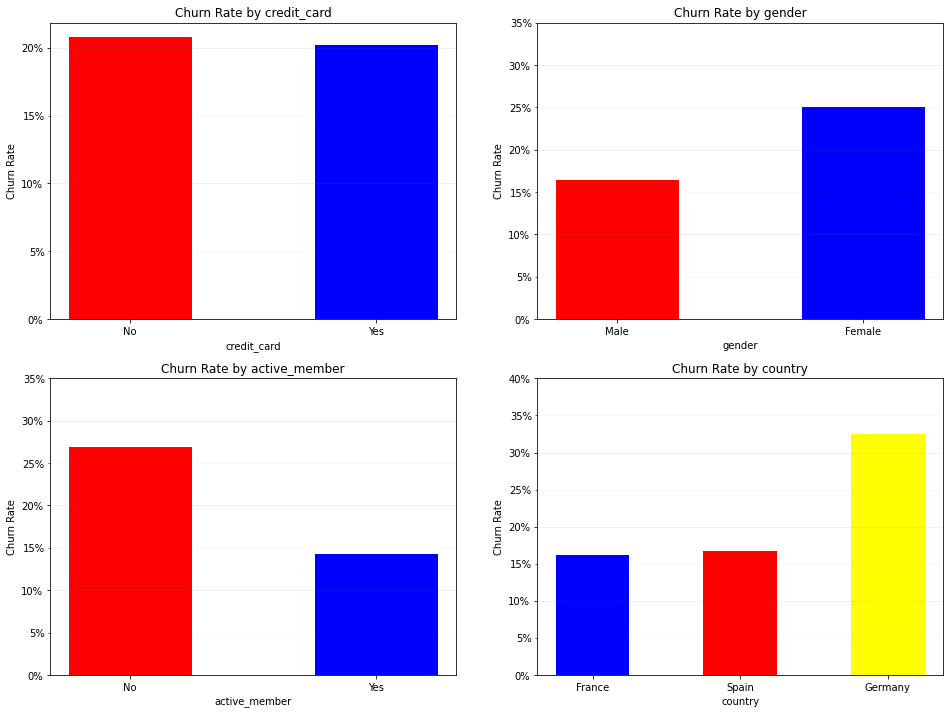

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member', 'country']
for iax, col, ymax in zip(ax.ravel(), cols, [.3, .4, .4, .5]):
    draw_rate(iax, df4, col)
    draw_grid(iax, ymax)
    
plt.savefig('images/frequencies.png')
plt.show()

### Frequency Plots by Country

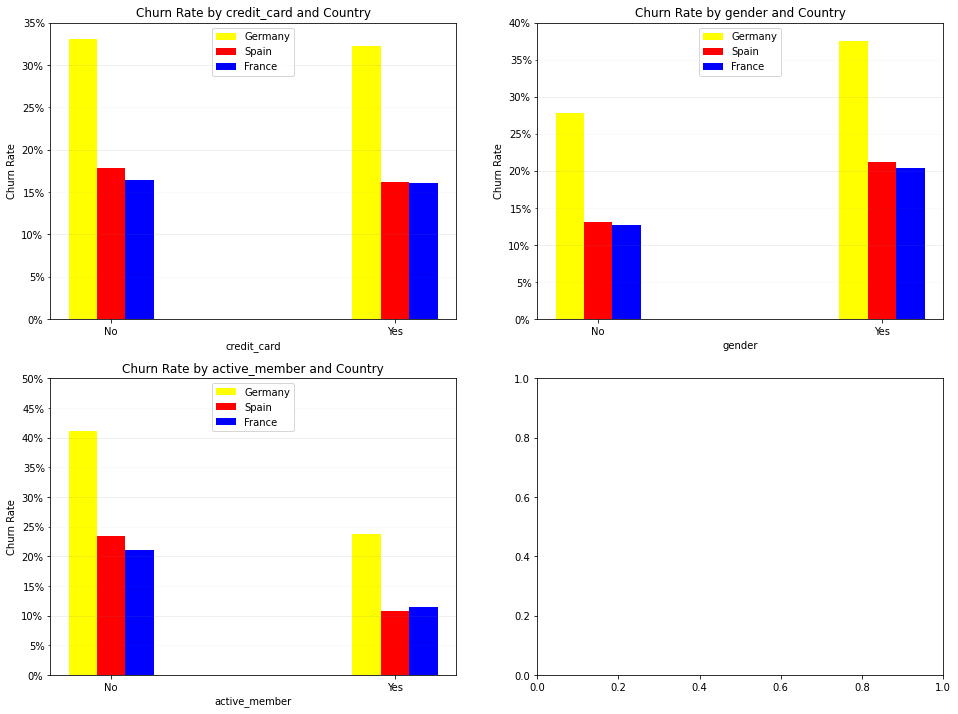

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member']
for iax, col, ymax in zip(ax.ravel(), cols, [.4, .5, .6]):
    draw_rate_country(iax, df4, col)
    draw_grid(iax, ymax)


plt.show()

# Data Preparation

In [60]:
df5 = df4.copy()

## Normalization

In [61]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

In [62]:
data = df5[cols_norm].copy()
scaler.fit(data)
df5[cols_norm] = scaler.transform(data)

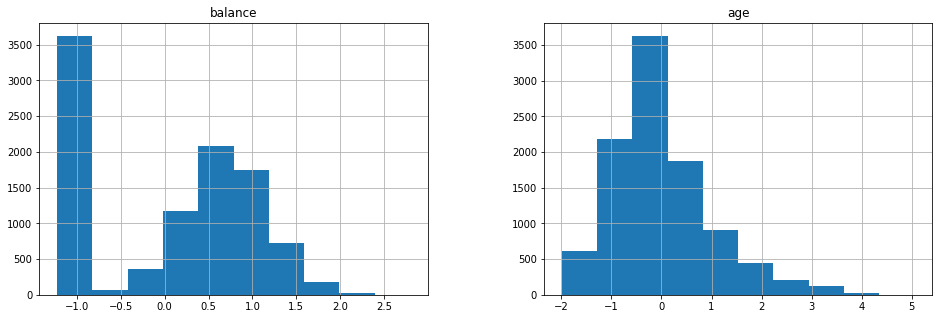

In [63]:
df5[cols_norm].hist(figsize=(16,5));

## Rescaling

In [64]:
cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

In [65]:
data = df5[cols_mms].copy()
mms.fit(data)
df5[cols_mms] = mms.transform(data)

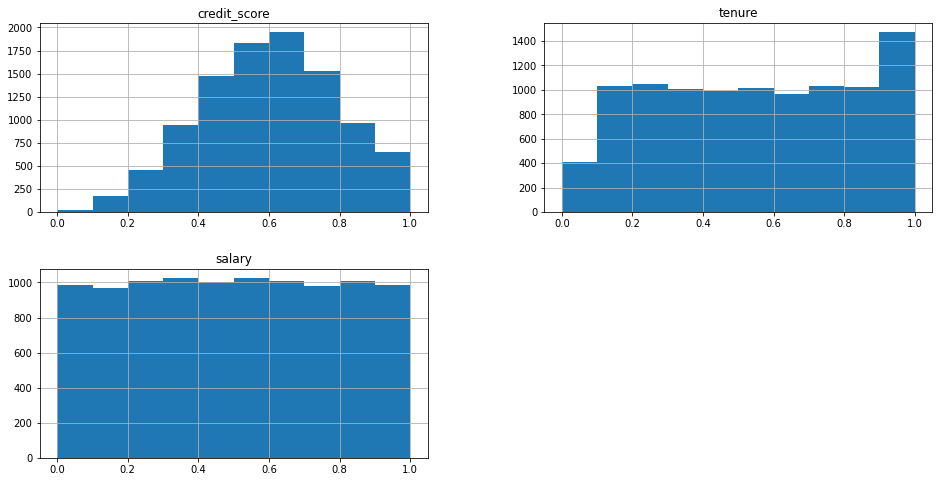

In [66]:
df5[cols_mms].hist(figsize=(16,8));

## Transformation

### Encoding

In [67]:
cols_ohe = ['geography', 'gender']
#cols_ohe = ['geography']
ohe = OneHotEncoder(sparse=False)

In [68]:
df5[cols_ohe].head(10)

,geography,gender
0,France,1
1,Spain,1
2,France,1
3,France,1
4,Spain,1
5,Spain,0
6,France,0
7,Germany,1
8,France,0
9,France,0


In [69]:
ohe.fit_transform(df5[cols_ohe])[:10]

array([[1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.]])

## Combining All Column Transformations

In [70]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder(drop='if_binary')

ct = make_column_transformer((scaler, cols_norm), (mms, cols_mms), (ohe, cols_ohe), remainder='passthrough')

### Testing the Column Transformer

In [71]:
dump = df2.copy()
dump.iloc[[0, 5]]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,0
5,645,Spain,0,44,8,113755.78,2,1,0,149756.71,1,1


In [72]:
ct.fit_transform(dump)[[0, 5]]

array([[-1.226,  0.294,  0.538,  0.2  ,  0.507,  1.   ,  0.   ,  0.   ,
         1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  0.   ],
       [ 0.597,  0.484,  0.59 ,  0.8  ,  0.749,  0.   ,  0.   ,  1.   ,
         0.   ,  2.   ,  1.   ,  0.   ,  1.   ,  1.   ]])

In [73]:
ct.named_transformers_['onehotencoder'].get_feature_names()

array(['x0_France', 'x0_Germany', 'x0_Spain', 'x1_1'], dtype=object)

In [74]:
model_cols = ['balance', 'age', 'credit_score', 'tenure', 'salary', 'france', 'germany', 'spain',
              'gender', 'num_products', 'credit_card', 'active_member']

# Machine Learning Models

In [92]:
df6 = reload_data()
print(', '.join(df6.columns))

X = df6.drop('exited', axis=1).copy()
y = df6.exited.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

credit_score, geography, gender, age, tenure, balance, num_products, credit_card, active_member, salary, exited


## Train Set Churn Rate - Pergunta 1: Qual a taxa de Churn atual da empresa?

In [16]:
total_churn = y_train.sum()
churn_ratio = total_churn / len(y_train)

print(f'The total churn rate in the training data set is {100.*churn_ratio:.2f}%')

The total churn rate in the training data set is 20.38%


## Modelling

### Column Transformer for Pipeline

In [17]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder(drop='if_binary')

ct = make_column_transformer((scaler, cols_norm), (mms, cols_mms), (ohe, cols_ohe), remainder='passthrough')

model_cols = ['balance', 'age', 'credit_score', 'tenure', 'salary', 'france', 'germany', 'spain',
              'gender', 'num_products', 'credit_card', 'active_member']

### Instatiation and Training of Models

In [75]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                        class_weight=None, random_state=42, solver='lbfgs', max_iter=100, multi_class='auto',
                        verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)


rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                            random_state=42, verbose=0, warm_start=False, class_weight=None,
                            ccp_alpha=0.0, max_samples=None)

nb = GaussianNB()

km = KMeans(n_clusters=2)

xg = XGBClassifier()

In [76]:
models = [lr, nb, rf, xg, km]
model_names = ['LogReg', 'GaussianNB', 'RandomForest', 'XGBoost', 'KMeans']
scoring = 'recall'

means = []
stds = []
for model, name in zip(models, model_names):
    pipe = make_pipeline(ct, model)
    cv = cross_val_score(pipe, X, y, cv=10, scoring=scoring)
    mean, std = cv.mean(), cv.std()
    means.append(mean)
    stds.append(std)
    print(f'{name}: {mean:.3f} +/- {std:.3f}')

LogReg: 0.211 +/- 0.032
GaussianNB: 0.370 +/- 0.029
RandomForest: 0.473 +/- 0.041
XGBoost: 0.489 +/- 0.042
KMeans: 0.495 +/- 0.229


Let's keep only RandomForest and XGBoost for now.  
KMeans seems very nice, but it does not predict probabilities, so something would have to be done.  
Maybe not worth the effort given the very high variance of the model.  
But interesting to see that it seems to pick up on the exited clusters.

### Final 2 Models

In [21]:
rf = RandomForestClassifier()
xg = XGBClassifier()

models = [rf, xg]
model_names = ['RandomForest', 'XGBoost']
scoring = 'recall'

y_probas = []
thresholds = np.arange(0.5, 1., .1)
recall_scores = []
for model, name in zip(models, model_names):
    pipe = make_pipeline(ct, model)
    y_proba = cross_val_predict(pipe, X_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
    y_probas.append(y_proba)
    print(f'Recalls for {name}:')
    scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        score = sk_recall_score(y_train, y_pred)
        scores.append(score)
        print(f'Threshold {threshold:.1f}: {score:.2f}')
    print()
    recall_scores.append(scores)

Recalls for RandomForest:
Threshold 0.5: 0.47
Threshold 0.6: 0.38
Threshold 0.7: 0.29
Threshold 0.8: 0.19
Threshold 0.9: 0.06

Recalls for XGBoost:
Threshold 0.5: 0.48
Threshold 0.6: 0.43
Threshold 0.7: 0.38
Threshold 0.8: 0.32
Threshold 0.9: 0.24



## Model Performance

### Precision-Recall Curve

In [22]:
precisions = []
recalls = []
for y_proba in y_probas:
    precision, recall, _ = precision_recall_curve(y_train, y_proba, pos_label=1)
    precisions.append(precision)
    recalls.append(recall)

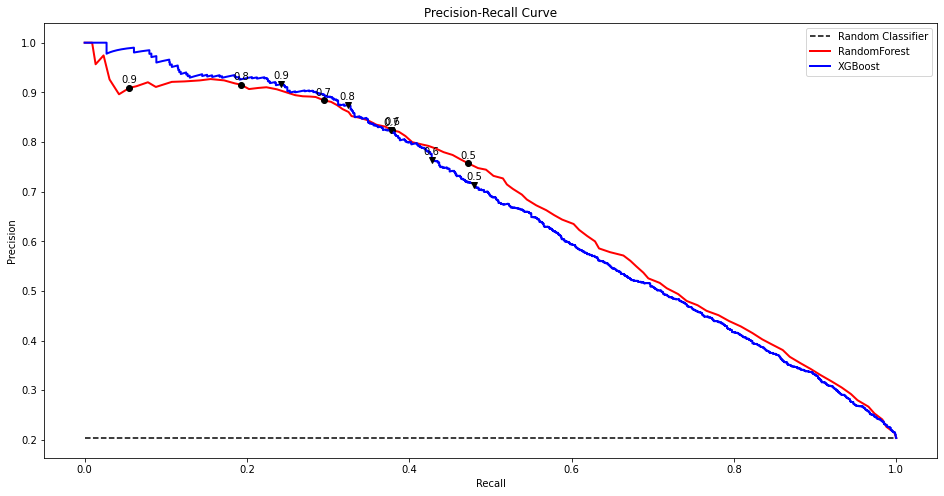

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

ax.plot([0, 1], [churn_ratio, churn_ratio], linestyle='--', color='black', label='Random Classifier')
for recall_score, recall, precision, label, c, marker in zip(recall_scores, recalls, precisions, model_names, ['red', 'blue'], ['o', 'v']):
    ax.plot(recall, precision, color=c, label=label, linewidth=2)
    
    for threshold, score in zip(thresholds, recall_score):
        index = find_nearest(recall, score)
        x = recall[index]
        y = precision[index]
        ax.plot(x, y, marker=marker, color='black')
        ax.annotate(f'{threshold:.1f}', xy=(x, y), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

plt.show()

### Confusion Matrix

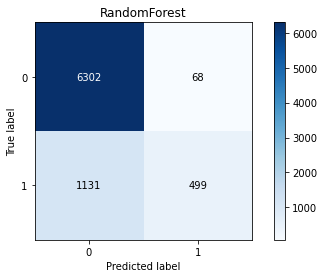

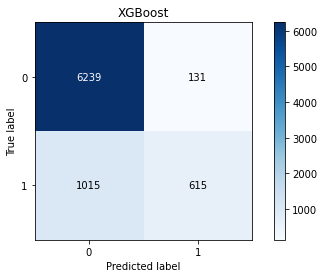

In [80]:
threshold = .7
for y_proba, model_name in zip(y_probas, model_names):
    ypred = (y_proba >= threshold).astype(int)
    skplt.metrics.plot_confusion_matrix(y_train, ypred, labels=None, true_labels=None,
                                        pred_labels=None, title=model_name, normalize=False,
                                        hide_zeros=False, hide_counts=False, x_tick_rotation=0,
                                        ax=None, figsize=(8,4), cmap='Blues',
                                        title_fontsize='large', text_fontsize='medium')

### Gains and Lift

In [81]:
step = .1
rates = []
lifts = []
gains = []

for y_proba in y_probas:
    rates.append(get_rate(y_train, y_proba, step=step))
    lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
    lifts.append(lift)
    gains.append(gain)

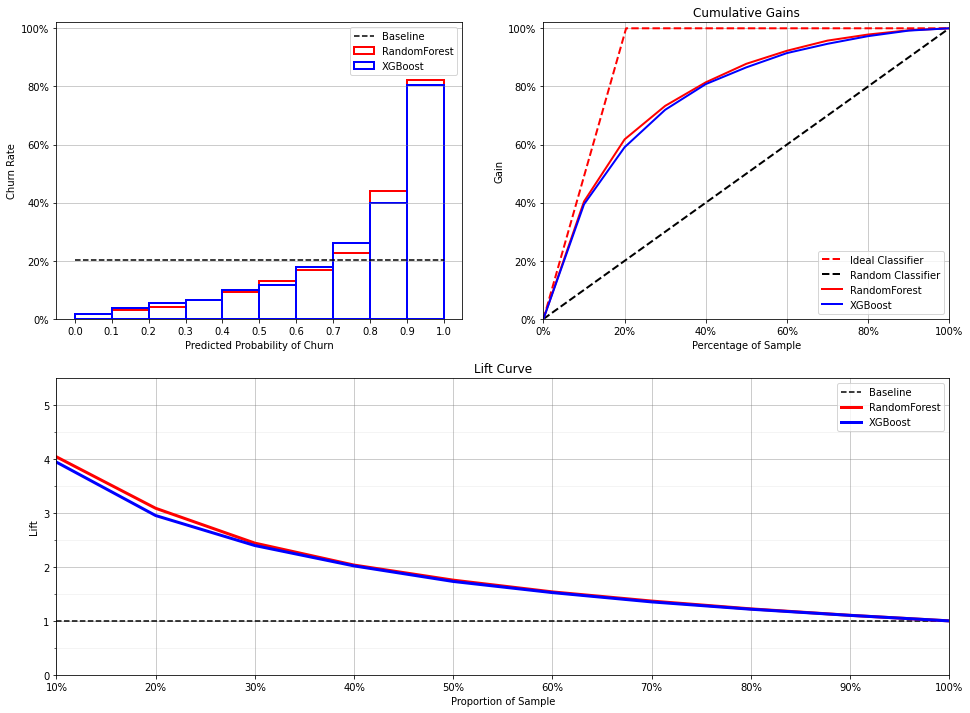

In [82]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
(ax1, ax2), (ax3, ax4) = ax

df = roi_xg_train.df
mask = (df.true==1)
bins = np.arange(0, 1.1, .1)
ax1.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Train Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Train Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

df = roi_xg_test.df
mask = (df.true==1)
bins = np.arange(0, 1.1, .1)
ax3.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax3.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax3.set_title('Test Class Separation')
ax3.set_xlabel('Probability of Churning')
ax3.legend()

ax4.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax4.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax4.set_title('Test Class Separation (log-scale)')
ax4.set_xlabel('Probability of Churning')
ax4.set_ylim(1, 6000)
ax4.legend()

plt.show()

### Class Separation

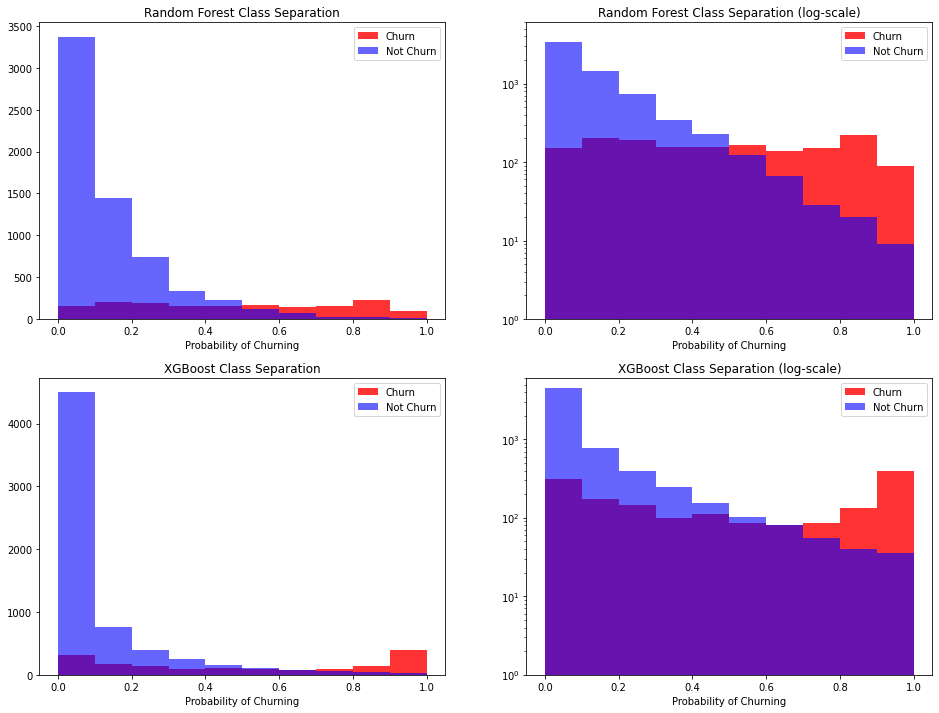

In [286]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
(ax1, ax2), (ax3, ax4) = ax

bins = np.arange(0, 1.1, .1)
ax1.hist(y_probas[0][y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(y_probas[0][~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Random Forest Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(y_probas[0][y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(y_probas[0][~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Random Forest Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

bins = np.arange(0, 1.1, .1)
ax3.hist(y_probas[1][y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax3.hist(y_probas[1][~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax3.set_title('XGBoost Class Separation')
ax3.set_xlabel('Probability of Churning')
ax3.legend()

ax4.hist(y_probas[1][y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax4.hist(y_probas[1][~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax4.set_title('XGBoost Class Separation (log-scale)')
ax4.set_xlabel('Probability of Churning')
ax4.set_ylim(1, 6000)
ax4.legend()

plt.show()

### Feature Importance

In [83]:
for model in models:
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)

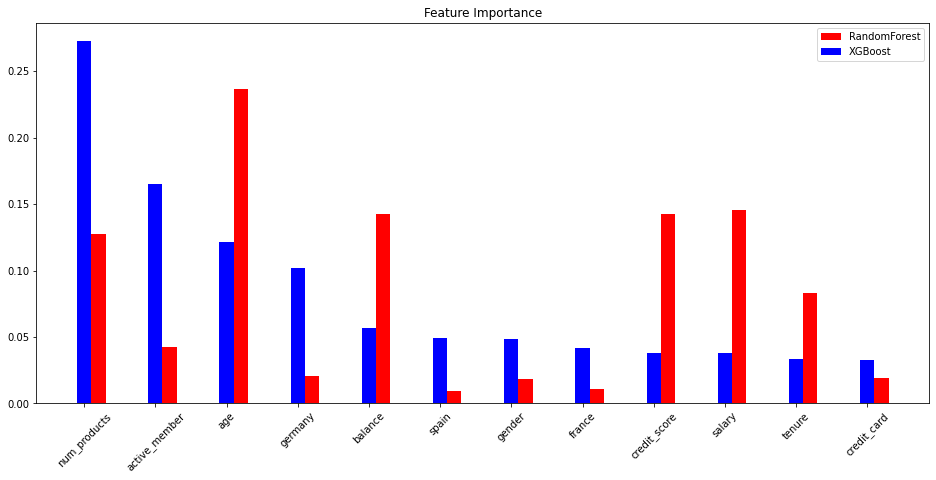

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))

order = np.argsort(xg.feature_importances_)[::-1]
names = np.array(model_cols)[order]

x = np.arange(0, len(names))
ax.bar(x=x+0.2, height=rf.feature_importances_[order], color='red', label='RandomForest', width=.2)
ax.bar(x=x, height=xg.feature_importances_[order], color='blue', label='XGBoost', width=.2)

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45)
ax.set_title(f'Feature Importance')
ax.legend(loc='upper right')

plt.savefig('images/feature_importance.png')
plt.show()

In [85]:
high_corr

['active_member', 'gender', 'balance', 'geography', 'age']

It seems to me that the Forest is picking up noise in the data.  
Unless there are some very weird patterns that we missed in the visual analysis,
credit_score and tenure are extremely similar, for example.  

I believe it was able to catch the small fluctuations there and it is over-fitting.  
We could move it forward and try to improve it, but since XGBoost seems more reasonable, I'll only continue with it.

### Calibration Curves

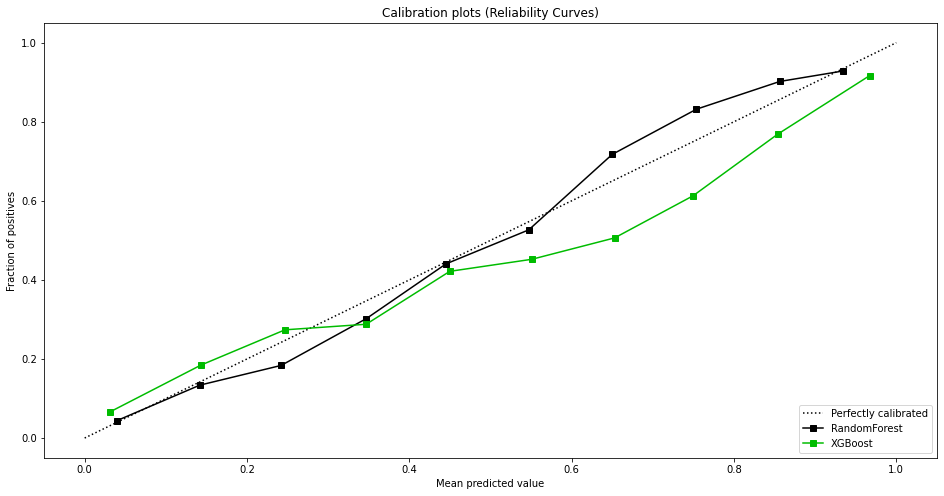

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

skplt.metrics.plot_calibration_curve(y_train, y_probas, clf_names=model_names, n_bins=10,
                                     title='Calibration plots (Reliability Curves)', ax=ax, figsize=None,
                                     cmap='nipy_spectral', title_fontsize='large', text_fontsize='medium')

plt.show()

## Model Fine Tuning

### Out-of-the-Box Performance

In [50]:
xg = XGBClassifier()
model_name = 'XGBoost'
scoring = 'recall'

pipe = make_pipeline(ct, xg)
y_proba = cross_val_predict(pipe, X_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
print(f'Recalls for {model_name}:')
for threshold in np.arange(0.5, 1., .1):
    y_pred = (y_proba >= threshold).astype(int)
    print(f'Threshold {threshold:.1f}: {sk_recall_score(y_train, y_pred):.2f}')

Recalls for XGBoost:
Threshold 0.5: 0.48
Threshold 0.6: 0.43
Threshold 0.7: 0.38
Threshold 0.8: 0.32
Threshold 0.9: 0.24


In [51]:
step = .1
rates = []
lifts = []
gains = []

rates.append(get_rate(y_train, y_proba, step=step))
lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names = [model_name]

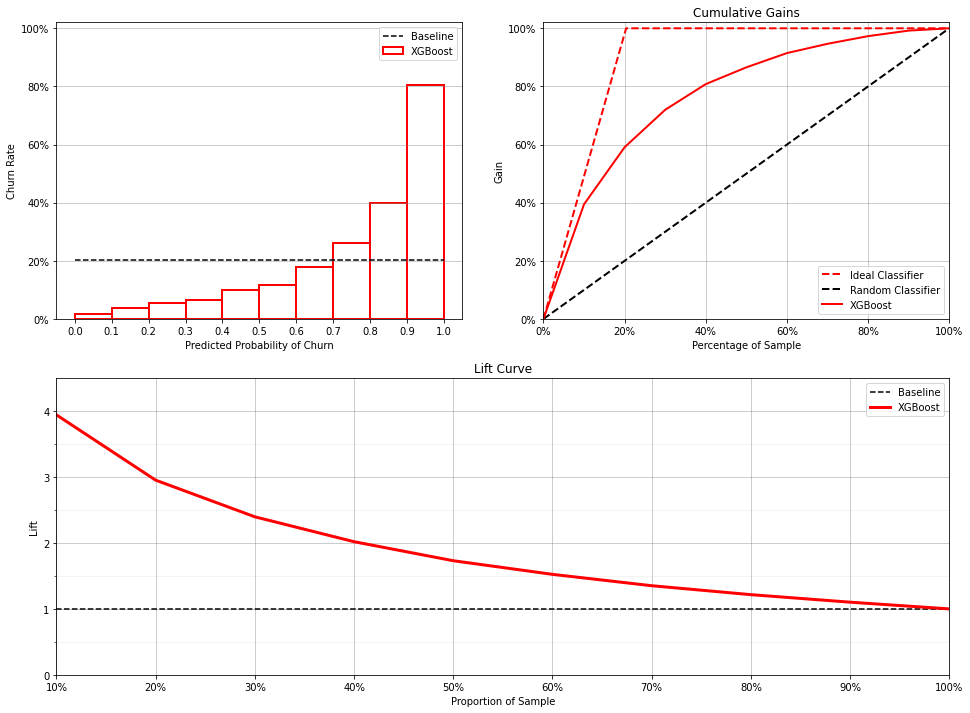

In [52]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.savefig('images/lift.png')
plt.show()

### Training With Most Important Features

In [53]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder(drop='if_binary')

ct2 = make_column_transformer((scaler, cols_norm), (ohe, cols_ohe), remainder='passthrough')
model_cols = ['balance', 'age', 'france', 'germany', 'spain', 'gender', 'num_products', 'active_member']
important_cols = ['balance', 'age', 'geography', 'gender', 'num_products', 'active_member']

In [93]:
X_roi = X.copy()
X_train_roi = X_train.copy()
X_test_roi = X_test.copy()

X = X[important_cols].copy()
X_train = X_train[important_cols].copy()
X_test = X_test[important_cols].copy()

In [170]:
# Only Testing Reduced Random Forest Performance
if False:
    models = [rf, xg]
    model_names = ['RandomForest', 'XGBoost']
    scoring = 'recall'

    y_probas = []
    thresholds = np.arange(0.5, 1., .1)
    recall_scores = []
    for model, name in zip(models, model_names):
        pipe = make_pipeline(ct2, model)
        y_proba = cross_val_predict(pipe, X_train2, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
        y_probas.append(y_proba)
        print(f'Recalls for {name}:')
        scores = []
        for threshold in thresholds:
            y_pred = (y_proba >= threshold).astype(int)
            score = sk_recall_score(y_train, y_pred)
            scores.append(score)
            print(f'Threshold {threshold:.1f}: {score:.2f}')
        print()
        recall_scores.append(scores)

    for y_proba in y_probas:
        rates.append(get_rate(y_train, y_proba, step=step))
        lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
        lifts.append(lift)
        gains.append(gain)
    model_names.append('reduced Random Forest')
    model_names.append('reduced XGBoost')

In [55]:
model_name = 'reduced XGBoost'
scoring = 'recall'

pipe = make_pipeline(ct2, xg)
y_proba = cross_val_predict(pipe, X_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
print(f'Recalls for {model_name}:')
for threshold in np.arange(0.5, 1., .1):
    y_pred = (y_proba >= threshold).astype(int)
    print(f'Threshold {threshold:.1f}: {sk_recall_score(y_train, y_pred):.2f}')

Recalls for reduced XGBoost:
Threshold 0.5: 0.49
Threshold 0.6: 0.42
Threshold 0.7: 0.36
Threshold 0.8: 0.30
Threshold 0.9: 0.23


In [56]:
rates.append(get_rate(y_train, y_proba, step=step))
lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names.append(model_name)

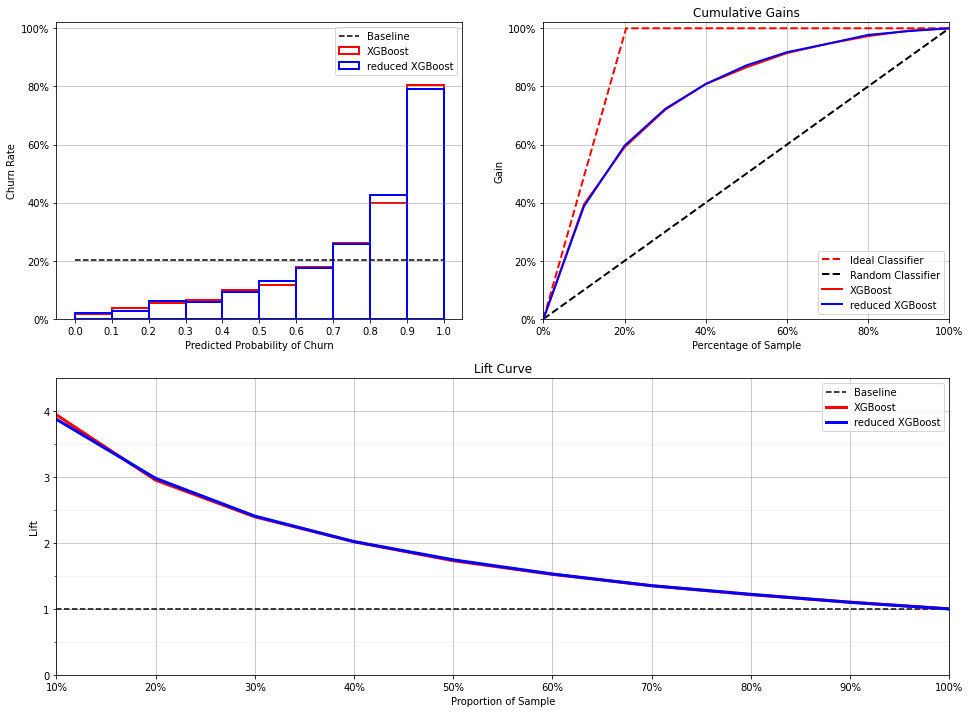

In [57]:
fig = plt.figure(figsize=(16,12))
grid = (2, 2)
ax1 = plt.subplot2grid(grid, (0, 0))
ax2 = plt.subplot2grid(grid, (0, 1))
ax3 = plt.subplot2grid(grid, (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.savefig('images/lift_reduced.png')
plt.show()

### Hyper-Parameter Optimization

In [58]:
#xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic')
pipe.named_steps.keys()

dict_keys(['columntransformer', 'xgbclassifier'])

In [59]:
clf_name = 'xgbclassifier'

params = {}
params[f'{clf_name}__min_child_weight'] = [1, 5, 10]
params[f'{clf_name}__gamma'] = [0.5, 1, 1.5, 2, 5]
params[f'{clf_name}__subsample'] = [0.6, 0.8, 1.0]
params[f'{clf_name}__colsample_bytree'] = [0.6, 0.8, 1.0]
params[f'{clf_name}__max_depth'] = [3, 4, 5]
params

{'xgbclassifier__min_child_weight': [1, 5, 10],
 'xgbclassifier__gamma': [0.5, 1, 1.5, 2, 5],
 'xgbclassifier__subsample': [0.6, 0.8, 1.0],
 'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
 'xgbclassifier__max_depth': [3, 4, 5]}

In [74]:
nfolds = 5
param_comb = 15

#grid = GridSearchCV(pipe, params, cv=nfolds, scoring='recall', n_jobs=4)
grid = RandomizedSearchCV(pipe, param_distributions=params, n_iter=param_comb,
                                   scoring='recall', n_jobs=4, cv=nfolds,
                                   verbose=3, random_state=1001 )

grid.fit(X_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    9.4s finished


In [75]:
results_random = pd.DataFrame(grid.cv_results_)
results_random.sort_values('rank_test_score', inplace=True)
results_random['RMS_Mean'] = 100.*results_random.std_test_score / results_random.mean_test_score
results_random[['mean_test_score', 'std_test_score', 'RMS_Mean']]

,mean_test_score,std_test_score,RMS_Mean
2,0.501227,0.030280,6.041108
14,0.498160,0.032901,6.604477
1,0.493252,0.023713,4.807500
4,0.493252,0.025985,5.268114
13,0.492638,0.024662,5.006165
8,0.490798,0.023361,4.759858
5,0.490184,0.022069,4.502154
9,0.488344,0.021110,4.322777
12,0.487730,0.036450,7.473434
7,0.485276,0.023554,4.853692


## Final Model

### Training

In [77]:
print(grid.best_score_)
grid.best_params_

0.5012269938650308


{'xgbclassifier__subsample': 0.8,
 'xgbclassifier__min_child_weight': 5,
 'xgbclassifier__max_depth': 5,
 'xgbclassifier__gamma': 1,
 'xgbclassifier__colsample_bytree': 0.8}

In [78]:
model_name = 'Tuned XGBoost'
scoring = 'recall'

pipe = grid.best_estimator_
y_proba = cross_val_predict(pipe, X_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
print(f'Recalls for {model_name}:')
for threshold in np.arange(0.5, 1., .1):
    y_pred = (y_proba >= threshold).astype(int)
    print(f'Threshold {threshold:.1f}: {sk_recall_score(y_train, y_pred):.2f}')

Recalls for Tuned XGBoost:
Threshold 0.5: 0.49
Threshold 0.6: 0.43
Threshold 0.7: 0.36
Threshold 0.8: 0.29
Threshold 0.9: 0.20


In [79]:
rates.append(get_rate(y_train, y_proba, step=step))
lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names.append(model_name)
model_names

['XGBoost', 'reduced XGBoost', 'Tuned XGBoost', 'Tuned XGBoost']

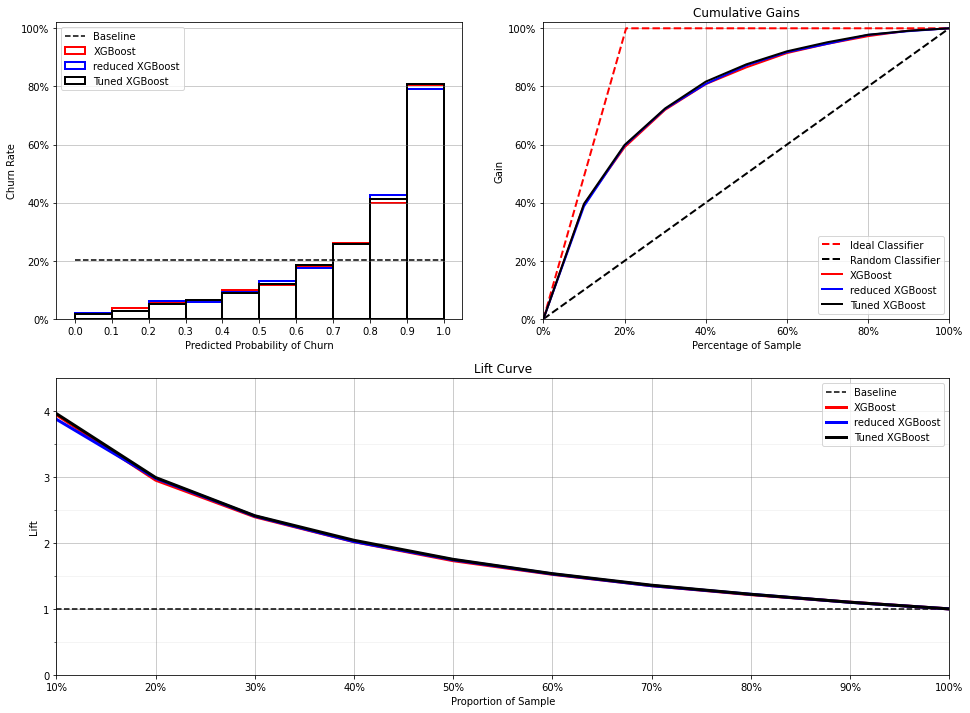

In [66]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.savefig('images/lift_final.png')
plt.show()

### Testing

In [88]:
step = .1
rates = []
lifts = []
gains = []
model_names = []

model_name = 'Train XGBoost'

pipe = grid.best_estimator_
y_train_proba = cross_val_predict(pipe, X_train, y=y_train, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
rates.append(get_rate(y_train, y_train_proba, step=step))
lift, gain = get_lift_gain(y_train, y_train_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names.append(model_name)

model_name = 'Test XGBoost'
y_test_proba = pipe.predict_proba(X_test)[:, 1]
rates.append(get_rate(y_test, y_test_proba, step=step))
lift, gain = get_lift_gain(y_test, y_test_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names.append(model_name)

model_names

['Train XGBoost', 'Test XGBoost']

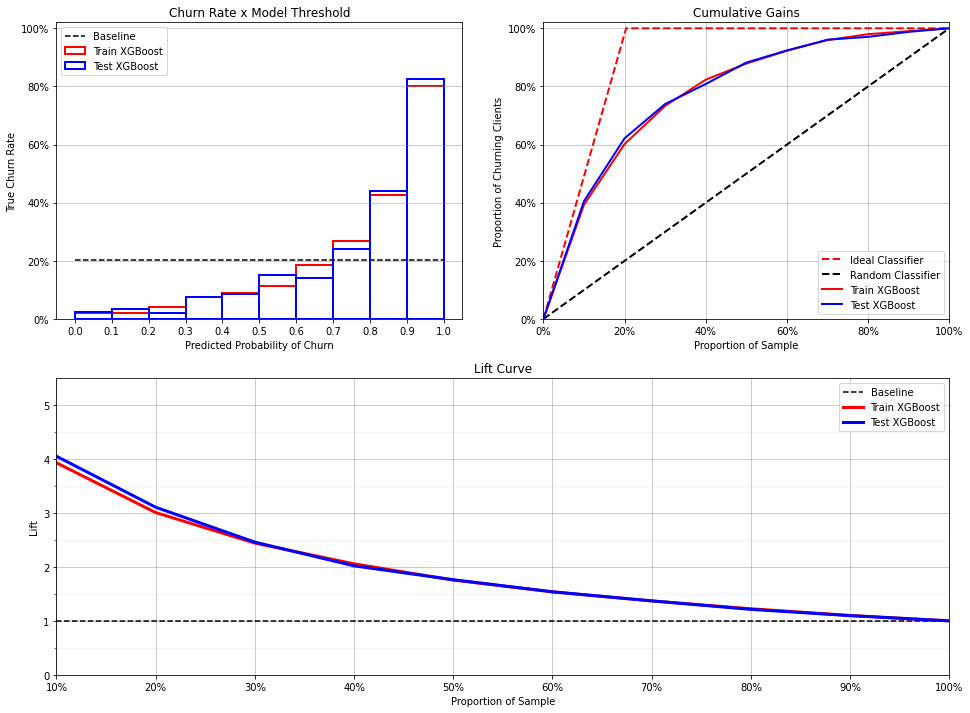

In [289]:
fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.savefig('images/lift_train-test.png')
plt.show()

### Class Separation

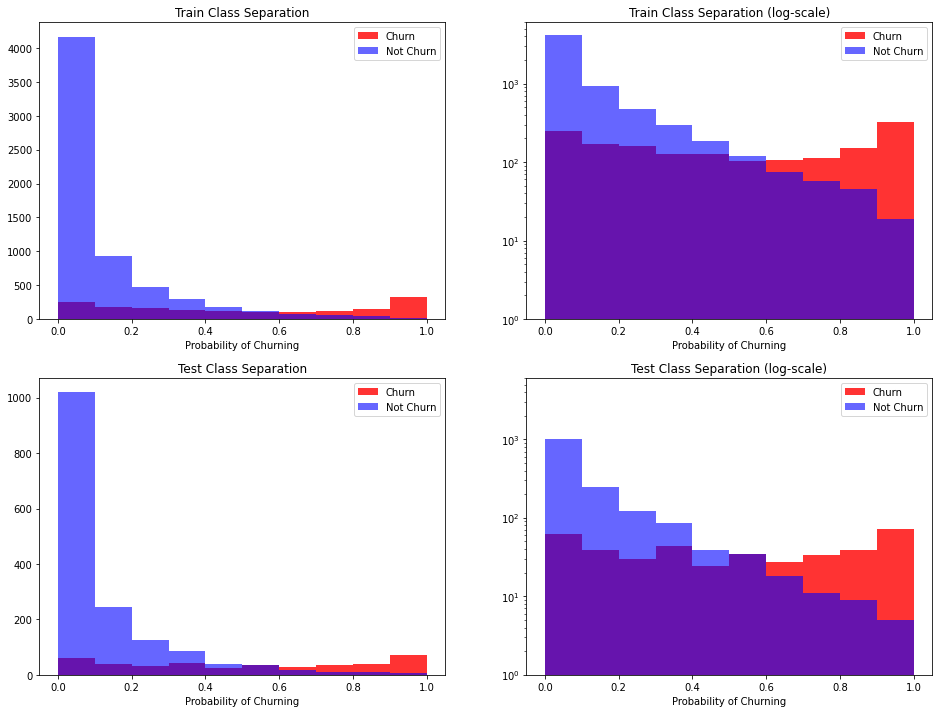

In [290]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
(ax1, ax2), (ax3, ax4) = ax

bins = np.arange(0, 1.1, .1)
ax1.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Train Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Train Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

bins = np.arange(0, 1.1, .1)
ax3.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax3.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax3.set_title('Test Class Separation')
ax3.set_xlabel('Probability of Churning')
ax3.legend()

ax4.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax4.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax4.set_title('Test Class Separation (log-scale)')
ax4.set_xlabel('Probability of Churning')
ax4.set_ylim(1, 6000)
ax4.legend()

plt.savefig('images/class_separation.png')
plt.show()

In [90]:
train_score = grid.best_score_
test_score = sk_recall_score(y_test, pipe.predict(X_test))

print(f'Train Score: {train_score:.2f}')
print(f'Test Score: {test_score:.2f}')

Train Score: 0.50
Test Score: 0.51


### Full Model

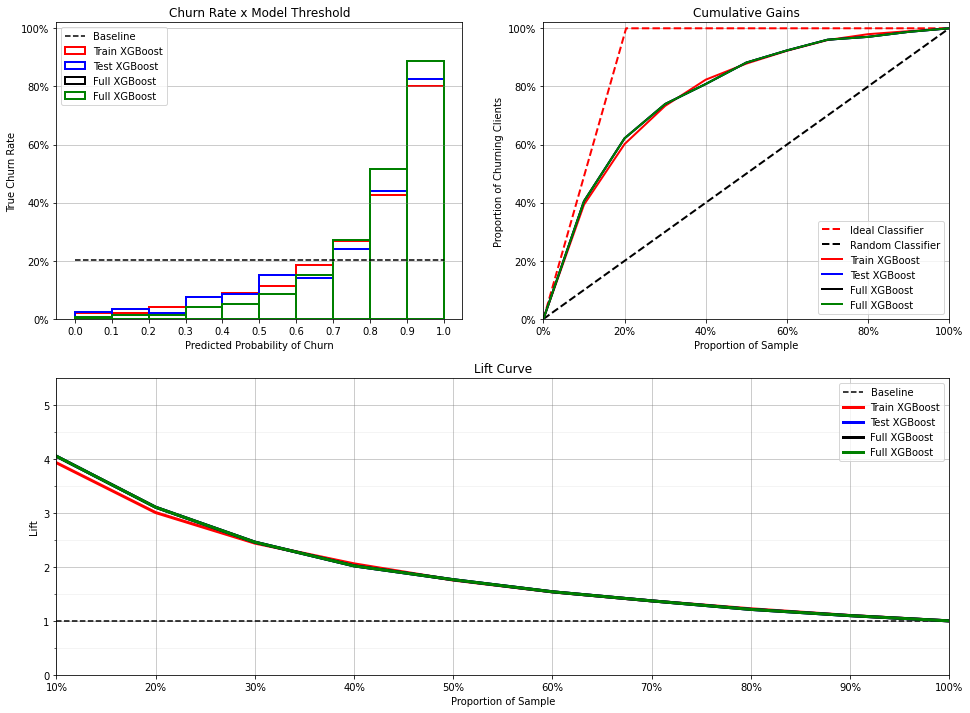

In [297]:
model_name = 'Full XGBoost'
y_full_proba = pipe.predict_proba(X)[:, 1]
rates.append(get_rate(y, y_full_proba, step=step))
lift, gain = get_lift_gain(y_test, y_test_proba, step=step, plot=False)
lifts.append(lift)
gains.append(gain)
model_names.append(model_name)

fig = plt.figure(figsize=(16,12))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

#plt.savefig('images/lift_full.png')
plt.show()

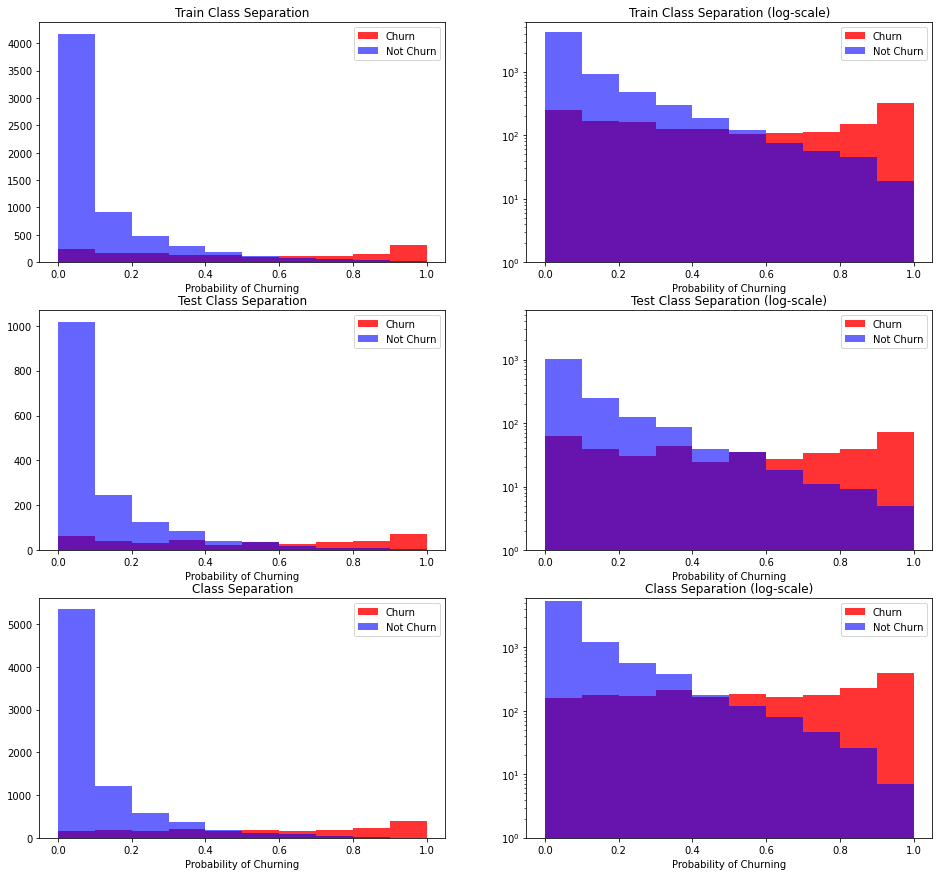

In [299]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,15))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = ax

bins = np.arange(0, 1.1, .1)
ax1.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Train Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(y_train_proba[y_train.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(y_train_proba[~y_train.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Train Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

ax3.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax3.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax3.set_title('Test Class Separation')
ax3.set_xlabel('Probability of Churning')
ax3.legend()

ax4.hist(y_test_proba[y_test.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax4.hist(y_test_proba[~y_test.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax4.set_title('Test Class Separation (log-scale)')
ax4.set_xlabel('Probability of Churning')
ax4.set_ylim(1, 6000)
ax4.legend()

ax5.hist(y_full_proba[y.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8)
ax5.hist(y_full_proba[~y.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6)
ax5.set_title('Class Separation')
ax5.set_xlabel('Probability of Churning')
ax5.legend()

ax6.hist(y_full_proba[y.astype(bool)], bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax6.hist(y_full_proba[~y.astype(bool)], bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax6.set_title('Class Separation (log-scale)')
ax6.set_xlabel('Probability of Churning')
ax6.set_ylim(1, 6000)
ax6.legend()

#plt.savefig('images/class_separation_full.png')
plt.show()

In [300]:
train_score = grid.best_score_
test_score = sk_recall_score(y_test, pipe.predict(X_test))
full_score = sk_recall_score(y, pipe.predict(X))

print(f'Train Score: {train_score:.2f}')
print(f'Test Score: {test_score:.2f}')
print(f'Full Score: {full_score:.2f}')

Train Score: 0.50
Test Score: 0.51
Full Score: 0.56


# Calculating ROI

In [111]:
for i in [.5, .6, .7, .8, .9]:
    print(f'Threshold set at {i}:')
    get_ROI(X_train_roi, y_train, y_train_proba, threshold=i, name='Train XGBoost')
    print('\n\n')

Threshold set at 0.5:
Performance of Train XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,878,638.24
Percentage of 100 clientes that were correctly identified as churning clients: 98.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.5):
ROI = $2,880,858.18
Percentage of 100 clientes that were correctly identified as churning clients: 76.0%

Performance of randomly selecting 100 clients:
ROI = $230,633.93
Percentage of 100 clientes that were correctly identified as churning clients: 17.0%

Performance of realisticaly selecting clients:
ROI = $4,452,973.74
Percentage of 200 clientes that were correctly identified as churning clients: 64.0%
Total invested: $10,000



Threshold set at 0.6:
Performance of Train XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,878,638.24
Percentage of 100 clientes that were correctly identified as churning clients: 98.0%

Performance of selecting the 100 richest clients (with Pchur

In [112]:
for i in [.5, .6, .7, .8, .9]:
    print(f'Threshold set at {i}:')
    get_ROI(X_test_roi, y_test, y_test_proba, threshold=i, name='Test XGBoost')
    print('\n\n')

Threshold set at 0.5:
Performance of Train XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,567,861.71
Percentage of 100 clientes that were correctly identified as churning clients: 91.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.5):
ROI = $2,553,797.60
Percentage of 100 clientes that were correctly identified as churning clients: 76.0%

Performance of randomly selecting 100 clients:
ROI = $280,286.12
Percentage of 100 clientes that were correctly identified as churning clients: 18.0%

Performance of realisticaly selecting clients:
ROI = $3,047,958.15
Percentage of 175 clientes that were correctly identified as churning clients: 66.9%
Total invested: $10,000



Threshold set at 0.6:
Performance of Train XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,567,861.71
Percentage of 100 clientes that were correctly identified as churning clients: 91.0%

Performance of selecting the 100 richest clients (with Pchur

In [115]:
roi_xg_train = get_ROI(X_train_roi, y_train, y_train_proba, threshold=.7, name='Train XGBoost')
print('\n\n')
roi_xg_test = get_ROI(X_test_roi, y_test, y_test_proba, threshold=.7, name='Test XGBoost')

Performance of Train XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,878,638.24
Percentage of 100 clientes that were correctly identified as churning clients: 98.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.7):
ROI = $3,111,009.45
Percentage of 100 clientes that were correctly identified as churning clients: 84.0%

Performance of randomly selecting 100 clients:
ROI = $262,421.87
Percentage of 100 clientes that were correctly identified as churning clients: 18.0%

Performance of realisticaly selecting clients:
ROI = $4,744,231.16
Percentage of 200 clientes that were correctly identified as churning clients: 78.0%
Total invested: $10,000



Performance of Test XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,567,861.71
Percentage of 100 clientes that were correctly identified as churning clients: 91.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.7):
ROI = $2,194,070.05
Percentage of 1

# Business Analysis

In [415]:
df = ROI(X_train_roi, y_train, y_train_proba, threshold=.5, name='Train', seed=int(10*.5)).get_results()
for i in np.arange(.6, 1., .1):
    dump = ROI(X_train_roi, y_train, y_train_proba, threshold=i, name='Train', seed=int(10*i)).get_results()
    df = pd.concat([df, dump])
    
for i in np.arange(.5, 1., .1):
    dump = ROI(X_test_roi, y_test, y_test_proba, threshold=i, name='Test', seed=int(20*i)).get_results()
    df = pd.concat([df, dump])
    
for i in np.arange(.5, 1., .1):
    dump = ROI(X_roi, y, y_full_proba, threshold=i, name='Full', seed=int(30*i)).get_results()
    df = pd.concat([df, dump])

In [249]:
compare = ['model', 'threshold', 'random_improve', 'random_ratio', 'top100_prob_improve', 'top100_prob_ratio',
          'top100_rich_improve', 'top100_rich_ratio', 'real_random_improve', 'real_random_ratio', 'real_improve', 'real_ratio']

In [409]:
df[compare]

,model,threshold,random_improve,random_ratio,top100_prob_improve,top100_prob_ratio,top100_rich_improve,top100_rich_ratio,real_random_improve,real_random_ratio,real_improve,real_ratio,top100_prob_ltv
0,Train,0.5,0.013312,0.834356,4.503117,5.764706,6.905450,4.470588,0.013312,0.834356,10.673829,3.764706,29460654.03
0,Train,0.6,0.014426,1.472393,4.155384,3.266667,6.807898,2.733333,0.013232,1.472393,11.818653,2.466667,29460654.03
0,Train,0.7,0.010875,0.981595,5.512213,4.900000,9.128179,4.200000,0.010836,0.981595,13.969855,3.900000,29460654.03
0,Train,0.8,0.010875,0.981595,5.512213,4.900000,9.332119,4.400000,0.010836,0.981595,12.307027,4.223602,29460654.03
0,Train,0.9,0.014554,1.079755,4.118724,4.454545,7.027348,4.272727,0.013718,1.079755,5.619096,4.069767,29460654.03
0,Test,0.5,0.025239,0.737101,8.291599,6.066667,13.505697,5.066667,0.018615,0.737101,21.855108,4.457143,5923989.30
0,Test,0.6,0.052605,1.081081,3.978228,4.136364,6.030058,3.590909,0.046480,1.081081,7.396528,3.455791,5923989.30
0,Test,0.7,0.054064,0.982801,3.870917,4.550000,5.416972,4.300000,0.048288,0.982801,5.980745,4.140625,5923989.30
0,Test,0.8,0.060165,0.982801,3.478341,4.550000,4.102790,4.400000,0.058454,0.982801,3.753165,4.387755,5923989.30
0,Test,0.9,0.077560,1.326781,2.698233,3.370370,2.175181,2.703704,0.075606,1.326781,1.819243,3.423120,5923989.30


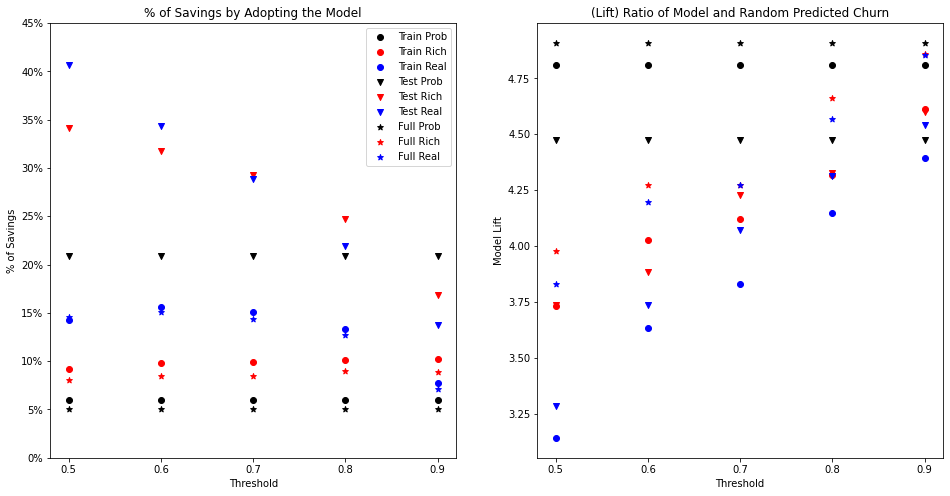

In [428]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

data_set = (df.model == 'Train')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_eps'], c='black', label='Train Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_eps'], c='red', label='Train Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_eps'], c='blue', label='Train Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_lift'], c='black', label='Train Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_lift'], c='red', label='Train Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_lift'], c='blue', label='Train Real')

data_set = (df.model == 'Test')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_eps'], c='black', marker='v', label='Test Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_eps'], c='red', marker='v', label='Test Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_eps'], c='blue', marker='v', label='Test Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_lift'], c='black', marker='v', label='Test Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_lift'], c='red', marker='v', label='Test Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_lift'], c='blue', marker='v', label='Test Real')

data_set = (df.model == 'Full')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_eps'], c='black', marker='*', label='Full Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_eps'], c='red', marker='*', label='Full Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_eps'], c='blue', marker='*', label='Full Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_lift'], c='black', marker='*', label='Full Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_lift'], c='red', marker='*', label='Full Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_lift'], c='blue', marker='*', label='Full Real')

ax1.set_title('% of Savings by Adopting the Model')
ax1.set_xticks(df.loc[train, 'threshold'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('% of Savings')
ax1.set_yticks(np.arange(0., .5, .05))
ax1.set_yticklabels([f'{100.*i:.0f}%' for i in np.arange(0., .5, .05)])
ax1.legend()

ax2.set_title('(Lift) Ratio of Model and Random Predicted Churn')
ax2.set_xticks(df.loc[train, 'threshold'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Model Lift')
#ax2.legend()

plt.show()

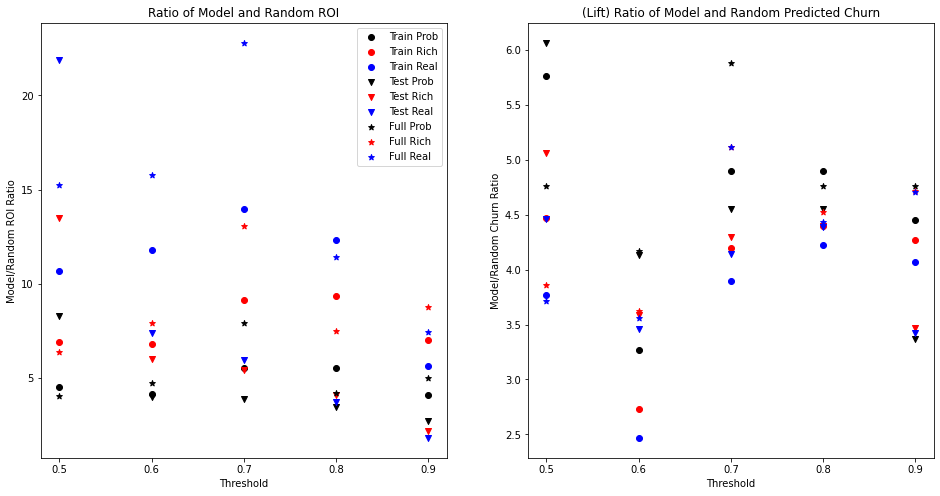

In [416]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

data_set = (df.model == 'Train')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_improve'], c='black', label='Train Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_improve'], c='red', label='Train Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_improve'], c='blue', label='Train Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_ratio'], c='black', label='Train Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_ratio'], c='red', label='Train Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_ratio'], c='blue', label='Train Real')

data_set = (df.model == 'Test')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_improve'], c='black', marker='v', label='Test Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_improve'], c='red', marker='v', label='Test Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_improve'], c='blue', marker='v', label='Test Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_ratio'], c='black', marker='v', label='Test Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_ratio'], c='red', marker='v', label='Test Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_ratio'], c='blue', marker='v', label='Test Real')

data_set = (df.model == 'Full')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_improve'], c='black', marker='*', label='Full Prob')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_improve'], c='red', marker='*', label='Full Rich')
ax1.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_improve'], c='blue', marker='*', label='Full Real')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_prob_ratio'], c='black', marker='*', label='Full Prob')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'top100_rich_ratio'], c='red', marker='*', label='Full Rich')
ax2.scatter(df.loc[data_set, 'threshold'], df.loc[data_set, 'real_ratio'], c='blue', marker='*', label='Full Real')

ax1.set_title('Ratio of Model and Random ROI')
ax1.set_xticks(df.loc[train, 'threshold'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Model/Random ROI Ratio')
ax1.legend()

ax2.set_title('(Lift) Ratio of Model and Random Predicted Churn')
ax2.set_xticks(df.loc[train, 'threshold'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Model/Random Churn Ratio')
#ax2.legend()

plt.show()

## Final Numbers

In [467]:
finaldf = df.loc[(df.model=='Full')&(df.threshold==.7)]

In [468]:
finaldf.columns

Index(['model', 'threshold', 'total_ltv', 'exiting_ltv', 'diff_ltv',
       'churn_ltv', 'pred_ltv', 'churn_ratio', 'investment', 'ncards',
       'random_roi', 'random_churn', 'random_ltv', 'random_improve',
       'random_ratio', 'top100_prob_roi', 'top100_prob_churn',
       'top100_prob_ltv', 'top100_prob_improve', 'top100_prob_ratio',
       'top100_prob_eps', 'top100_prob_lift', 'top100_rich_ncards',
       'top100_rich_roi', 'top100_rich_churn', 'top100_rich_ltv',
       'top100_rich_improve', 'top100_rich_ratio', 'top100_rich_eps',
       'top100_rich_lift', 'real_random_roi', 'real_random_churn',
       'real_random_ltv', 'real_random_improve', 'real_random_ratio',
       'real_ncards', 'real_roi', 'real_churn', 'real_ltv', 'real_improve',
       'real_ratio', 'real_eps', 'real_lift'],
      dtype='object')

In [490]:
LTV = finaldf.total_ltv[0]
exiting_LTV = finaldf.exiting_ltv[0]
actual_LTV = finaldf.diff_ltv[0]
random_roi = finaldf.random_roi[0]
random_improv = 100.*finaldf.random_improve[0]
rich_roi = finaldf.top100_rich_roi[0]
rich_improv = 100.*finaldf.top100_rich_eps[0]
rich_random = finaldf.top100_rich_improve[0]
rich_lift = finaldf.top100_rich_lift[0]
rrandom_roi = finaldf.real_random_roi[0]
rrandom_improv = 100.*finaldf.real_random_improve[0]
real_roi = finaldf.real_roi[0]
real_improv = 100.*finaldf.real_eps[0]
real_random = finaldf.real_improve[0]
real_lift = finaldf.real_lift[0]

print(f'Total Revenue before customers left: ${LTV:,.2f}')
print(f'Total Revenue lost: ${exiting_LTV:,.2f}')
print(f'Lost Rev % of total: {100.*exiting_LTV/LTV:.1f}%')
print(f'Actual Revenue: ${actual_LTV:,.2f}')

print(f'\nRandomly giving 100 $100 gift cards we can keep ${random_roi:,.2f}, {random_improv:.1f}% of the lost Revenue.')
print(f'Implementing AI to identify churning customers we can save ${rich_roi:,.2f}, {rich_improv:.1f}% of the lost Revenue.')
print(f'This represents {rich_random:.1f}x more than what the random model can save,\nby correctly predicting {rich_lift:.1f}x more churning customers.')

print(f'\nAssuming a more realistic scenario, where not all clients can be retained:')
print(f'Randomly giving 100 $100 gift cards we can keep ${rrandom_roi:,.2f}, {rrandom_improv:.1f}% of the lost Revenue.')
print(f'Implementing AI + Knapsack to identify which churning customers to keep, we can save ${real_roi:,.2f}, {real_improv:.1f}% of the lost Revenue.')
print(f'This represents {real_random:.1f}x more than what the random model can save,\nby correctly predicting {real_lift:.1f}x more churning customers.')

Total Revenue before customers left: $187,612,077.14
Total Revenue lost: $38,846,324.65
Lost Rev % of total: 20.7%
Actual Revenue: $148,765,752.49

Randomly giving 100 $100 gift cards we can keep $249,919.56, 0.6% of the lost Revenue.
Implementing AI to identify churning customers we can save $3,271,376.74, 8.4% of the lost Revenue.
This represents 13.1x more than what the random model can save,
by correctly predicting 4.3x more churning customers.

Assuming a more realistic scenario, where not all clients can be retained:
Randomly giving 100 $100 gift cards we can keep $244,342.48, 0.6% of the lost Revenue.
Implementing AI + Knapsack to identify which churning customers to keep, we can save $5,569,809.49, 14.3% of the lost Revenue.
This represents 22.8x more than what the random model can save,
by correctly predicting 4.3x more churning customers.


# Final model in Production

In [431]:
model_name = 'Final XGBoost'

pipe = grid.best_estimator_
y_proba = cross_val_predict(pipe, X, y=y, cv=10, n_jobs=-1, method='predict_proba')[:, 1]
print(f'Recalls for {model_name}:')
for threshold in np.arange(0.5, 1., .1):
    y_pred = (y_proba >= threshold).astype(int)
    print(f'Threshold {threshold:.1f}: {sk_recall_score(y, y_pred):.2f}')

Recalls for Final XGBoost:
Threshold 0.5: 0.49
Threshold 0.6: 0.42
Threshold 0.7: 0.36
Threshold 0.8: 0.29
Threshold 0.9: 0.21


In [434]:
pipe.fit(X, y)
y_proba = pipe.predict_proba(X)[:, 1]
for threshold in np.arange(0.5, 1., .1):
    y_pred = (y_proba >= threshold).astype(int)
    print(f'Threshold {threshold:.1f}: {sk_recall_score(y, y_pred):.2f}')

Threshold 0.5: 0.57
Threshold 0.6: 0.48
Threshold 0.7: 0.40
Threshold 0.8: 0.32
Threshold 0.9: 0.22


Need to fix the ct to drop all non-informative columns automatically and pass the ones that are used but unmodified.  

Then, new_entries can be read directly from source (df?, app?) and passed to final_model to get a prediction!

In [449]:
threshold = 0.7
new_entries = X.iloc[0:1]
final_model = pipe
y_proba = final_model.predict_proba(new_entries)[:, 1]
y_pred = (y_proba >= threshold).astype(int)
y_pred

array([0])